# Introduzione <a id="intro"></a>

Il presente progetto è stato sviluppato nell'ambito del corso di Fondamenti di Analisi dei Dati dal dott. Danilo Santitto. L'obiettivo principale del progetto è applicare le tecniche e i metodi appresi durante il corso per analizzare un dataset reale, estrapolare informazioni significative, generare intuizioni utili relative alla classificazione. L'analisi si concentrerà su vari aspetti dei dati, tra cui la pulizia e la preparazione dei dati, l'analisi esplorativa, regressione e classificazione, clustering.

Il dataset assegnato per questa analisi è l'[Internet Advertisement dataset](https://archive.ics.uci.edu/dataset/51/internet+advertisements), un insieme di dati che rappresenta un insieme di possibili annunci pubblicitari su pagine Internet. Il compito principale associato a questo dataset è prevedere se un'immagine è un annuncio pubblicitario ("ad") o meno ("nonad").

## Indice:
* [Descrizione del Dataset](#descr-dataset)
* [Caricamento dei dati](#caricamento-dati)
    * [Acquisizione del Dataset](#acquisizione-dataset)
* [Pre-processing dei dati](#pre-processing)
    * [Gestione valori mancanti](#valori-mancanti)
* [Analisi dei dati ](#analisi-dati)
    * [Statistiche Descrittive](#statistiche-descrittive)
    * [Distribuzione dei dati](#distribuzione-dati)
    * [Outliers](#outliers)
* [Riduzione di dimensionalità](#riduzione-dimensionalita)
* [Valutazione della Separabilità delle Classi con LDA](#lda)
* [Regressione e Classificazione](#regressione-e-classificazione)
    * [Regressione Logistica](#reg-logistica)
        <!-- * [Baseline](#baseline-reg)
        * [PCA](#pca-reg) -->
    * [Bilanciamento del dataset](#bilanciamento-dataset)
        <!-- * [Undersampling](#undersampling)
        * [SMOTE](#smote) -->
    * [Support Vector Machine](#svm)
        <!-- * [Baseline](#baseline-svm)
        * [PCA](#pca-svm) -->
    * [Alberi Decisionali](#alberi)
        <!-- * [Baseline](#baseline-dt)
        * [PCA](#pca-dt) -->
    * [Random Forest](#random-forest)
        <!-- * [Baseline](#baseline-rf)
        * [PCA](#pca-rf) -->
    * [K-NN](#k-nn)
* [Clustering](#clustering)
    * [K-Medoids](#k-medoids)
* [Conclusioni](#conclusioni)


# Descrizione del Dataset <a id="descr-dataset"></a>

Internet Advertisement Dataset è stato generato tra aprile e luglio 1998. È composto da 3279 istanze, di cui 2821 sono classificate come "nonad" e 458 come "ad". Ogni istanza è descritta da 1558 attributi, di cui 3 continui e il resto binari. Gli attributi continui possono essere mancanti nel 28% delle istanze secondo quanto segnalato dalla documentazione. Di seguito si propone uno schema della sua struttura:
* **Nome del Dataset**: Internet Advertisement Dataset
* **Origine**: Creato da Nicholas Kushmerick tra aprile e luglio 1998.
* **Numero di Istanze**: 3279 istanze, suddivise in 2821 "nonad" e 458 "ad".
* **Numero di Attributi**: 1558 attributi, di cui 3 continui e il resto binari costituiti da variabily dummy, raggruppabili in "url", "origurl", "ancurl", "alt" e "caption".
* **Valori Mancanti**: Il 28% delle istanze manca di uno o più attributi continui.
* **Descrizione degli Attributi**: Gli attributi continui codificano la geometria dell'immagine (se disponibile); Gli attributi binari sono relativi alla presenza o meno di frasi che si verificano nell'URL dell'immagine, nell'URL e nel testo alternativo dell'immagine, nel testo dell'ancora e nelle parole che si verificano vicino al testo dell'ancora.

Si noti inoltre che non è presente una suddivisione in train e test set prestabilita dagli autori del dataset. Il dataset viene distribuito secondo la seguente struttura:
* **ad.names**, qui sono presenti tutti i nomi dei 1558 attributi presenti;
* **ad.data**, qui sono presenti tutti i 3279 records del dataset;
* **ad.DOCUMENTATION**: documentazione distribuita insieme al dataset.

# Caricamento dei Dati <a id="caricamento-dati"></a>

## Imports

In [1]:
# Install requirements
%pip install --user -qr ./requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from statsmodels.formula.api import logit
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import graphviz 
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn_extra.cluster import KMedoids
from sklearn.metrics import silhouette_score

## Acquisizione del Dataset <a id="acquisizione-dataset"></a>

Di seguito si procede ad acquisire il dataset. Si utilizza l'encoding ISO-8859-1 a causa di alcuni caratteri non standard nel file.

In [3]:
# Estrazione nomi colonne del dataset
with open('ad.names', encoding='ISO-8859-1') as fp:
    cols = []
    for line in fp:
        line = line.strip()
        if line.endswith(': continuous.') or line.endswith(': 0,1.'):
            colname = line.split(':')[0]
            cols.append(colname)
    cols.append('Class')

In [4]:
# Caricamento del dataset utilizzando i nomi delle colonne estratti
options = {
    'header': None, # il file non ha riga di intestazione
    'names': cols, 
    'skipinitialspace': True,
    'low_memory': False}
df = pd.read_csv('ad.data', **options)

Di seguito si osserva la struttura del dataset:

In [5]:
df

,height,width,aratio,local,url*images+buttons,url*likesbooks.com,url*www.slake.com,url*hydrogeologist,url*oso,url*media,...,caption*home,caption*my,caption*your,caption*in,caption*bytes,caption*here,caption*click,caption*for,caption*you,Class
0,125,125,1.0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ad.
1,57,468,8.2105,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ad.
2,33,230,6.9696,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ad.
3,60,468,7.8,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ad.
4,60,468,7.8,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ad.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3274,170,94,0.5529,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,nonad.
3275,101,140,1.3861,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,nonad.
3276,23,120,5.2173,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,nonad.
3277,?,?,?,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,nonad.


In [6]:
df.dtypes

height                object
width                 object
aratio                object
local                 object
url*images+buttons     int64
                       ...  
caption*here           int64
caption*click          int64
caption*for            int64
caption*you            int64
Class                 object
Length: 1559, dtype: object

I valori mancanti vengono indicati con **'?'** nel dataset, per cui per essere elaborati con pandas, vengono sostituiti con **nan**.

In [7]:
# Vengono mostrate le colonne affette da dati mancanti
columns_with_question_mark = (df == "?").any()
columns_with_question_mark[columns_with_question_mark].index

Index(['height', 'width', 'aratio', 'local'], dtype='object')

In [8]:
df = df.replace('?', np.nan)

Viene impostato il tipo corretto per le feature che presentano valori mancanti

In [9]:
df['height'] = df['height'].astype(float)
df['width'] = df['width'].astype(float)
df['aratio'] = df['aratio'].astype(float)
df['local'] = df['local'].astype(float)

# Pre-processing dei dati <a id="pre-processing"></a>

## Mappatura Classi

La variabile categorica Class è un object, ma è una variabile binaria, dunque si decide di cambiare il type da object ad int con:
* 0 = nonad.
* 1 = ad.

In [10]:
df['Class'] = df['Class'].map({'nonad.': 0, 'ad.': 1}).astype(int)

## Split train e test set

In [11]:
train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)
train_set = train_set.reset_index(drop=True)
test_set = test_set.reset_index(drop=True)

In [12]:
print(train_set.shape)
print(test_set.shape)

(2623, 1559)
(656, 1559)


## Gestione valori mancanti <a id="valori-mancanti"></a>

### Test Set

Per il test set, si procede all'eliminazione dei records con valori mancanti in quanto non si vuole minare l'integrità dei dati in alcun modo.

In [13]:
test_set.isna().sum()

height                184
width                 184
aratio                186
local                   3
url*images+buttons      0
                     ... 
caption*here            0
caption*click           0
caption*for             0
caption*you             0
Class                   0
Length: 1559, dtype: int64

In [14]:
test_set.dropna(inplace=True)

In [15]:
test_set.isna().sum()

height                0
width                 0
aratio                0
local                 0
url*images+buttons    0
                     ..
caption*here          0
caption*click         0
caption*for           0
caption*you           0
Class                 0
Length: 1559, dtype: int64

In [16]:
test_set['local'] = test_set['local'].astype(int)
test_set.shape

(467, 1559)

### Train Set

Verifica dei valori mancanti come indicato dalla documentazione

In [17]:
train_set.isna().sum()

height                719
width                 717
aratio                724
local                  12
url*images+buttons      0
                     ... 
caption*here            0
caption*click           0
caption*for             0
caption*you             0
Class                   0
Length: 1559, dtype: int64

Visto il numero elevato di colonne, si vuole essere certi che le colonne affette da dati mancanti siano esattamente 4.

In [18]:
columns_with_missing_values = train_set.isna().sum() > 0
columns_with_missing_values[columns_with_missing_values]

height    True
width     True
aratio    True
local     True
dtype: bool

Come ci si aspettava rispetto alla documentazione, il dataset presenta diversi dati mancanti, di seguito il totale dei record affetti:

In [19]:
missing_data_rows = (train_set.isna().sum(axis=1) > 0).sum()
print(missing_data_rows)
print(str(round(missing_data_rows * 100 / train_set.shape[0], 2)) + "%")

731
27.87%


#### Gestione dati mancanti variabli continue Height, Width, Aratio

In [20]:
# Verifica che aratio = width/height
print(round(train_set.loc[1, 'width'] / train_set.loc[1, 'height'], 4), train_set.loc[1, 'aratio'])

1.0 1.0


Considerato che:
* I valori mancanti si concentrano nelle features `Height`, `Width`, `Aratio`;
* `aratio = width/height`

ci si occuperà di gestire i valori mancanti in height e width per poi ricavare aratio da essi.

Di seguito il numero di records con le features height, width, aratio con dati mancanti:

In [21]:
(train_set[['height', 'width', 'aratio']].isna().any(axis=1)).sum()

724

Metodi per la loro gestione:

* **Eliminazione diretta delle colonne**: Come si nota, le features principalmente affette sono quelle con dati continui relative alle immagini. Una soluzione potrebbe essere l'eliminazione di `height`, `width` e `aratio`. Porterebbe ad una perdita dell'informazione.

* **Eliminazione records**: Eliminare direttamente le righe con dati mancanti. Soluzione indicata per poche righe con dati mancanti, in questo caso si andrebbero ad eliminare 910 records, ovvero 27.75% del totale. Si vuole evitare una perdita ingente di informazione utile nelle variabili dummy.

* **Imputazione con la media o mediana**: avendo grossa parte dei valori mancanti, la media stimata potrebbe discostarsi di molto da quella effettiva;

* **Imputazione con moda**: viene mantenuta l'indipendenza delle osservazioni (le adv sono indipendenti per ogni record), non ha bisogno di ordinamenti, di contro si potrebbe sovrastimare la frequenza di caratteristiche comuni.

* **Imputazione KNN**: Le osservazioni sono considerate come punti nello spazio delle features e i valori mancanti sono stimati sulla base dei k vicini più prossimi.


Si è deciso di procedere con l'imputazione della moda per height e width e ricavare da essa aratio.

In [22]:
height_mode = train_set['height'].mode()[0]
width_mode = train_set['width'].mode()[0]

# Imputo i valori mancanti
train_set['height'].fillna(height_mode, inplace=True)
train_set['width'].fillna(width_mode, inplace=True)
train_set['aratio'].fillna(width_mode/height_mode, inplace=True)

#### Local

Local è una variabile dummy che indica se l'immagine proviene dal dominio di origine della pagina web o da un dominio diverso. Di seguito i records con la feature local con dati mancanti:

In [23]:
(train_set[['local']].isna().any(axis=1)).sum()

12

Considerando che sono solo 12 i record con local indefinito, si procede all'eliminazione di questi records.

In [24]:
train_set = train_set.dropna(subset=['local'])
train_set['local'] = train_set['local'].astype(int)

Osservazione dati puliti

In [25]:
train_set.isna().sum()

height                0
width                 0
aratio                0
local                 0
url*images+buttons    0
                     ..
caption*here          0
caption*click         0
caption*for           0
caption*you           0
Class                 0
Length: 1559, dtype: int64

# Analisi dei dati <a id="analisi-dati"></a>

Dalla prima revisione è emerso che visualizzare i dati è possibile facilmente solo per le variabili continue, meno per le variabili dummy. Si è comunque provato ad effettuare un conteggio degli 1 e zero per ogni variabile per capire quanto sparso è il dataset.

## Statistiche Descrittive <a id="statistiche-descrittive"></a>

In [26]:
pd.set_option('display.max_columns', None)
train_set.describe(include='all')

height        width       aratio        local  url*images+buttons  \
count  2611.000000  2611.000000  2611.000000  2611.000000         2611.000000   
mean     62.596323   239.290693     4.926099     0.771352            0.004213   
std      47.397886   177.487901     5.051376     0.420042            0.064783   
min       1.000000     1.000000     0.001500     0.000000            0.000000   
25%      32.000000    90.000000     1.296400     1.000000            0.000000   
50%      60.000000   150.000000     4.500000     1.000000            0.000000   
75%      60.000000   468.000000     7.800000     1.000000            0.000000   
max     640.000000   640.000000    60.000000     1.000000            1.000000   

       url*likesbooks.com  url*www.slake.com  url*hydrogeologist      url*oso  \
count         2611.000000        2611.000000         2611.000000  2611.000000   
mean             0.012256           0.004979            0.003064     0.003447   
std              0.110047           0.070399            0.055279     0.058621   
min              0.000000           0.000000            0.000000     0.000000   
25%              0.000000           0.000000            0.000000     0.000000   
50%              0.000000           0.000000            0.000000     0.000000   
75%              0.000000           0.000000            0.000000     0.000000   
max              1.000000           1.000000            1.000000     1.000000   

         url*media  url*peace+images  url*blipverts  url*tkaine+kats  \
count  2611.000000       2611.000000    2611.000000      2611.000000   
mean      0.011107          0.003447       0.003064         0.008809   
std       0.104822          0.058621       0.055279         0.093459   
min       0.000000          0.000000       0.000000         0.000000   
25%       0.000000          0.000000       0.000000         0.000000   
50%       0.000000          0.000000       0.000000         0.000000   
75%       0.000000          0.000000       0.000000         0.000000   
max       1.000000          1.000000       1.000000         1.000000   

       url*labyrinth  url*advertising+blipverts  url*images+oso  \
count    2611.000000                2611.000000     2611.000000   
mean        0.005362                   0.003064        0.003447   
std         0.073043                   0.055279        0.058621   
min         0.000000                   0.000000        0.000000   
25%         0.000000                   0.000000        0.000000   
50%         0.000000                   0.000000        0.000000   
75%         0.000000                   0.000000        0.000000   
max         1.000000                   1.000000        1.000000   

       url*area51+corridor  url*ran+gifs  url*express-scripts.com     url*off  \
count          2611.000000   2611.000000              2611.000000  2611.00000   
mean              0.005362      0.003064                 0.005745     0.00383   
std               0.073043      0.055279                 0.075592     0.06178   
min               0.000000      0.000000                 0.000000     0.00000   
25%               0.000000      0.000000                 0.000000     0.00000   
50%               0.000000      0.000000                 0.000000     0.00000   
75%               0.000000      0.000000                 0.000000     0.00000   
max               1.000000      1.000000                 1.000000     1.00000   

          url*cnet  url*time+1998  url*josefina3  url*truluck.com  \
count  2611.000000    2611.000000    2611.000000      2611.000000   
mean      0.002681       0.004213       0.004213         0.005362   
std       0.051718       0.064783       0.064783         0.073043   
min       0.000000       0.000000       0.000000         0.000000   
25%       0.000000       0.000000       0.000000         0.000000   
50%       0.000000       0.000000       0.000000         0.000000   
75%       0.000000       0.000000       0.000000         0.000000   
max       1.00000

Principali considerazioni:
* **height e width**: media width (239.29) è molto superiore media height (62.59), con std maggiore nella dimensione orizzontale rispetto a quella verticale.
* **aratio**: Il valore medio è 4.92, indicando che l'ampiezza è mediamente circa cinque volte l'altezza. Std elevata.
* **local**: Colonna binaria con un valore medio di 0.77, suggerendo che la maggior parte dei valori assunti è 1.
* La quasi totalità delle variabili categoriche binarie ha una media molto piccola in valore, suggerendo che la maggior parte dei valori assume 0, dunque il dataset risulta sparso.

 ## Distribuzione dei dati <a id="distribuzione-dati"></a>

### Distribuzione delle classi

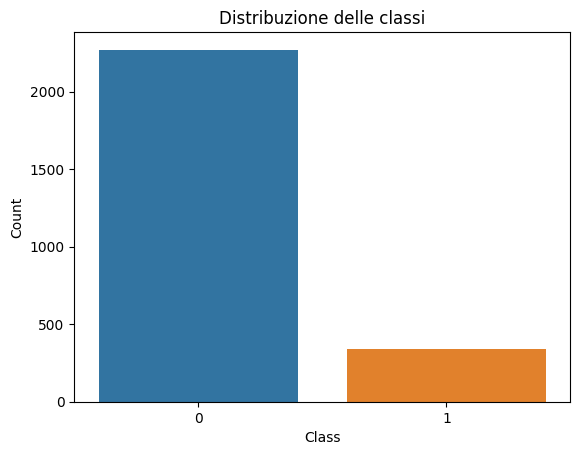

In [27]:
sns.countplot(data=train_set, x='Class')
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Distribuzione delle classi')
plt.show()

Come si può apprezzare, il dataset risulta fortemente sbilanciato verso le Class "nonad. = 0", ottenendo molti meno campioni per "ad. = 1". In una sezione successiva si valuteranno tecniche di bilanciamento del dataset.

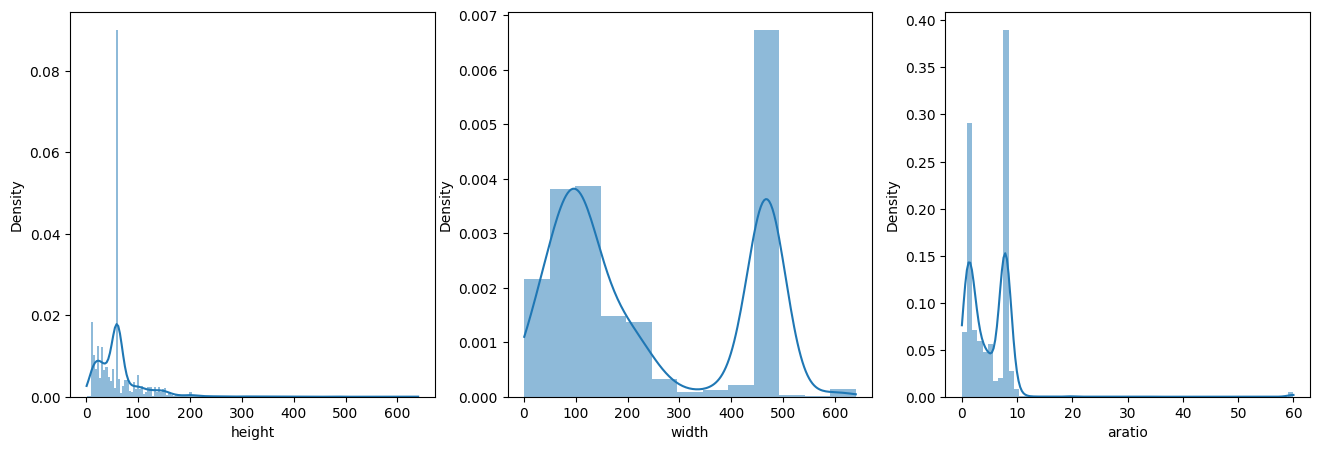

In [28]:
fig, ax = plt.subplots(nrows=1, ncols=3)
fig.set_figheight(5)
fig.set_figwidth(16)

sns.histplot(train_set['height'], kde=True, stat="density", linewidth=0, ax=ax[0])
sns.histplot(train_set['width'], kde=True, stat="density", linewidth=0, ax=ax[1])
sns.histplot(train_set['aratio'], kde=True, stat="density", linewidth=0, ax=ax[2])

plt.show()

Si nota in parte una positive skew per le variabili continue, i picchi rilevati potrebbero essere causati dall'imputazione della moda effettuata per sopperire ai dati mancanti.

<Axes: >

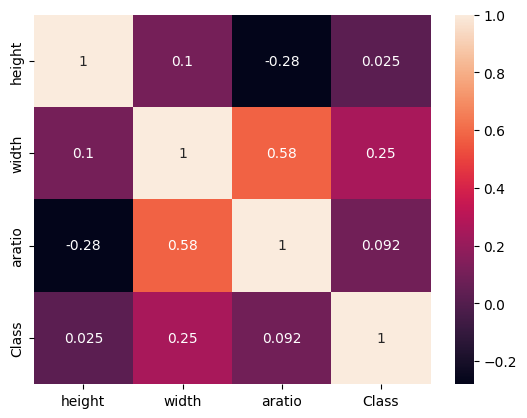

In [29]:
sns.heatmap(train_set.iloc[:,[0,1,2,1558]].corr(),annot=True)

Si può notare una buona correlazione (Pearson) tra le variabili continue inerenti alle immagini.

Si vuole mostrare per le variabili dummy quanto è sparso il dataset, si applica un conteggio in cluster tramite un grafico interattivo.

In [30]:
# Raggruppa le variabili dummy in cluster
url_features = train_set[[col for col in train_set.columns if col.startswith('url*')]]
origurl_features = train_set.filter(like='origurl*')
ancurl_features = train_set.filter(like='ancurl*')
alt_features = train_set.filter(like='alt*')
caption_features = train_set.filter(like='caption*')
clusters = [url_features, origurl_features, ancurl_features, alt_features, caption_features]
cluster_names = ['url', 'origurl', 'ancurl', 'alt', 'caption']

# Creazione della figura interattiva con sottoplot per ogni cluster
fig = make_subplots(rows=len(clusters), cols=1, subplot_titles=cluster_names)

# Aggiunta dei grafici a barre interattivi per ogni cluster
for i, cluster in enumerate(clusters):
    counts = cluster.sum()
    fig.add_trace(go.Bar(x=counts.index, y=counts.values, hovertemplate="Class: %{x}<br>Occorrenze di 1: %{y}"), row=i+1, col=1)

# Aggiunta dei titoli e impostazioni del layout
fig.update_layout(height=500*len(clusters), title_text="Numero di occorrenze di 1 per cluster di variabili dummy")
fig.update_xaxes(tickangle=45, tickfont=dict(size=8), showgrid=False)
fig.update_yaxes(title_text="Numero di occorrenze di 1")

fig.show()


Come si può osservare, il dataset risulta molto sparso, poche variabili superano il 2% circa (>50) dei records nel numero di occorrenze di 1.

## Outliers <a id="outliers"></a>

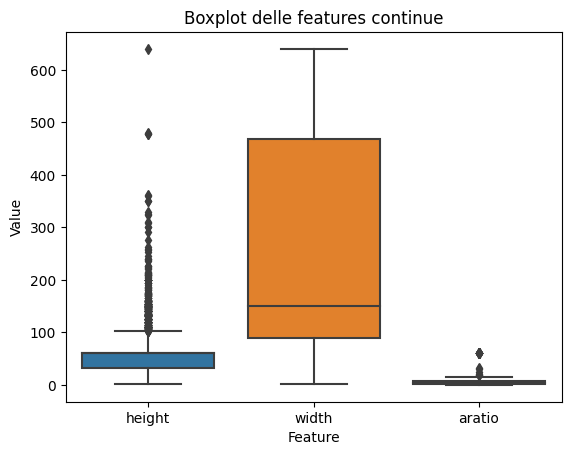

In [31]:
sns.boxplot(data=train_set.iloc[:, :3])
plt.xlabel('Feature')
plt.ylabel('Value')
plt.title('Boxplot delle features continue')
plt.show()

Vengono valutati gli outlier per le variabili continue: la prima componente presenta possibili outlier che andrebbero indagati, comunque i valori rientrano nell'intorno di width.

# Riduzione di dimensionalità <a id="riduzione-dimensionalita"></a>

## Perfetta Multicollinearità

La perfetta multicollinearità è una situazione in cui due o più variabili indipendenti in un modello di regressione multivariata sono linearmente correlate in maniera esatta. In altre parole, una variabile può essere espressa come una combinazione lineare esatta delle altre. Matematicamente, per esempio, se avessimo tre variabili $(X_1)$, $(X_2)$ e $(X_3)$, avremmo una situazione di perfetta multicollinearità se esistesse una relazione del tipo $(X_1 = aX_2 + bX_3)$, dove $(a)$ e $(b)$ sono costanti.

Si è sperimentato nelle sezioni successive che la presenza di multicollinearità perfetta può causare problemi nei modelli di regressione, poiché può portare a stime dei coefficienti instabili e ad un'interpretazione problematica delle variabili ed una mancata convergenza.

Si analizza dunque la presenza di perfetta multicollinearità nel dataset.

In [32]:
# Calcolo la matrice di correlazione
correlation_matrix = train_set.corr(method='spearman')

# Trova le coppie di colonne correlate
correlated_pairs = {}
for i in range(correlation_matrix.shape[1]):
    # Itero solo per la metà superiore della matrice di correlazione (esclusa la diagonale) visto che la metà inferiore avrebbe gli stessi risultati
    for j in range(i+1, correlation_matrix.shape[1]):
        col = correlation_matrix.columns[i]
        idx = correlation_matrix.index[j]
        correlation = correlation_matrix.iloc[j, i]
        # Cerca solo le coppie di colonne con correlazione esatta di 1
        if correlation == 1:
            correlated_pairs[col] = idx

print("Numero di coppie perfettamente correlate: ", len(correlated_pairs))
for col1, col2 in correlated_pairs.items():
     print(col1, col2)

Numero di coppie perfettamente correlate:  817
url*likesbooks.com origurl*www.likesbooks.com
url*www.slake.com ancurl*slake.com
url*hydrogeologist ancurl*www.ems.psu.edu
url*oso ancurl*ora.com
url*blipverts url*static.wired.com
url*labyrinth url*labyrinth+9439
url*advertising+blipverts url*static.wired.com
url*images+oso ancurl*ora.com
url*area51+corridor url*corridor
url*express-scripts.com origurl*www.express-scripts.com
url*off url*off+gif
url*time+1998 url*time
url*josefina3 origurl*horn
url*truluck.com origurl*truluck.com
url*clawnext+gif url*clawnext
url*autopen.com url*www.autopen.com
url*pixs ancurl*www.2meta.com
url*heartland+5309 origurl*5309+index
url*www.internauts.ca origurl*www.internauts.ca
url*afn.org origurl*afn.org
url*ran.org ancurl*www.ran.org
url*shareware.com ancurl*sw
url*baons+images origurl*www.theinternetadvantage.com
url*area51+labyrinth url*labyrinth+9439
url*image+navigate url*navigate
url*pool+images ancurl*toyotaofroswell.com
url*carousel.org origurl*www.

Come si puà notare dall'output sopra, esistono diverse coppie di variabili che sono affette da perfetta multicollinearità. Si nota inoltre che spesso queste coppie fanno riferimento ad una stringa comune all'interno delle variabili. Si sceglie dunque di mantenere solo una di queste variabili, effettuando feature selection sulla base della correlazione perfetta tra le variabili in esame.

In [33]:
# Rimuove una variabile da ciascuna coppia altamente correlata sia dal train set che dal test set
train_set_reduced = train_set.drop(columns=correlated_pairs.keys())
test_set_reduced = test_set.drop(columns=correlated_pairs.keys())
print(train_set_reduced.shape)

(2611, 742)


Si sono dunque ottenute 742 features utili.

## PCA <a id="pca"></a>

Il numero di feature è ancora molto alto, dunque si è scelto di valutare una riduzione delle features tramite PCA per effettuare un'analisi completa. Le variabili dummy sono raggruppabili in cluster come segue: url, origurl, ancurl, alt, caption.

Si definiscono le seguenti funzioni ausiliarie:

In [34]:
def show_pca_var_plot(pca, cluster_title):
    explained_variance = pca.explained_variance_ratio_
    plt.figure(figsize=(10, 5))
    plt.bar(range(len(explained_variance)), explained_variance, alpha=0.5,
            align='center', label=cluster_title + ' individual explained variance')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()
    plt.show()

In [35]:
def apply_pca(train_df, test_df, n_components=0.70, show_plots=False):
    feature_groups = {
        "url": [col for col in train_df.columns if col.startswith('url*')],
        "origurl": [col for col in train_df.columns if 'origurl*' in col],
        "ancurl": [col for col in train_df.columns if 'ancurl*' in col],
        "alt": [col for col in train_df.columns if 'alt*' in col],
        "caption": [col for col in train_df.columns if 'caption*' in col]
    }

    # Applica la PCA ad ogni feature group
    pca_models = {}
    for group_name, features in feature_groups.items():
        pca = PCA(n_components=n_components)
        pca.fit(train_df[features]) 
        pca_models[group_name] = pca 

    # Trasforma i dati di addestramento e di test utilizzando PCA
    for df in [train_df, test_df]:
        pca_features = []
        for group_name, features in feature_groups.items():
            pca_result = pca_models[group_name].transform(df[features])
            if show_plots and df is train_df:
                show_pca_var_plot(pca_models[group_name], group_name)
            pca_features.append(pca_result)

        # Concatena di nuovo insieme i feartures group trasformati da PCA
        pca_df = pd.DataFrame(
            np.concatenate([
                df[['height', 'width', 'aratio', 'local']].to_numpy(), 
                *pca_features,
                df[['Class']].to_numpy()
            ], axis=1)
        )

        # Aggiunta nomi colonne
        column_names = ['height', 'width', 'aratio', 'local']

        for (group, pca_result) in zip(feature_groups.keys(), pca_features):
            for i in range(pca_result.shape[1]):
                column_names.append(f"{group}_c{i}")

        column_names.append('Class')
        pca_df.columns = column_names
        pca_df['local'] = pca_df['local'].astype(int)
        pca_df['Class'] = pca_df['Class'].astype(int)

        if df is train_df:
            train_pca_df = pca_df
        else:
            test_pca_df = pca_df

    return train_pca_df, test_pca_df

Di seguito viene mostrato lo Scree plot per ogni feature group

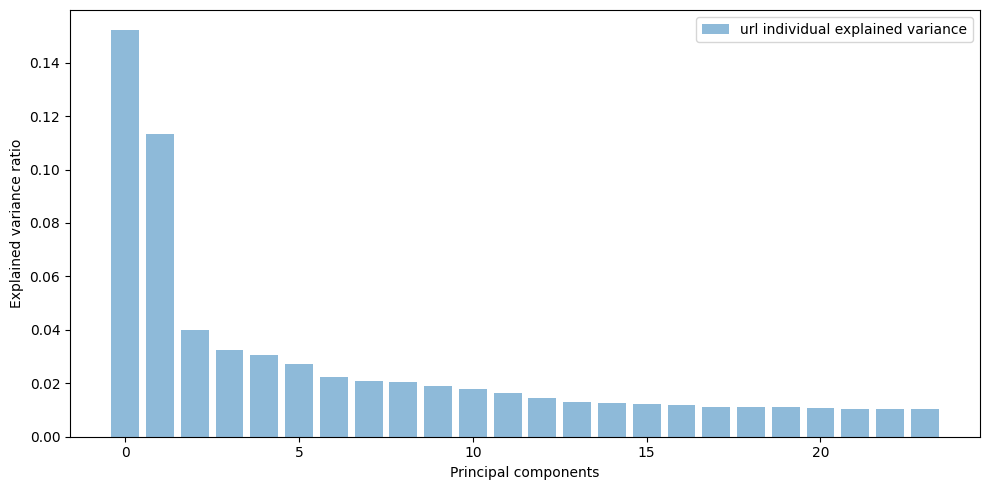

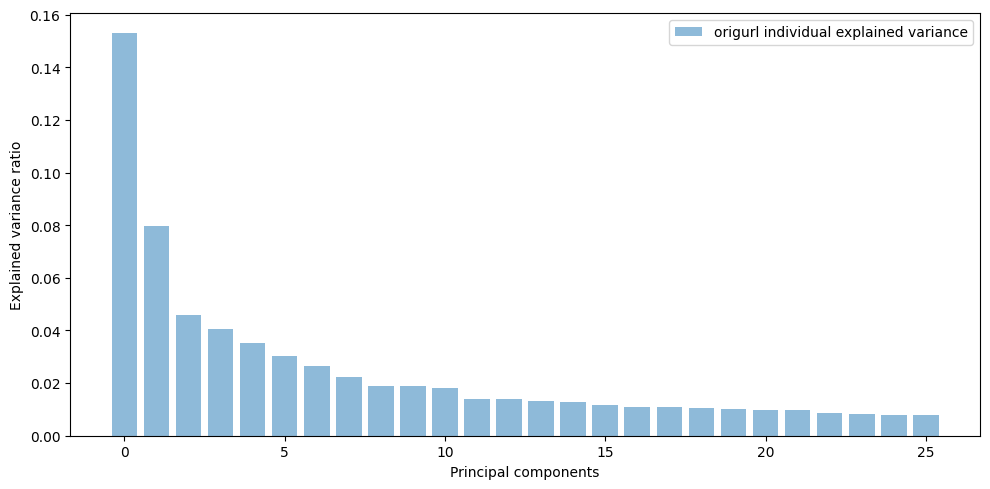

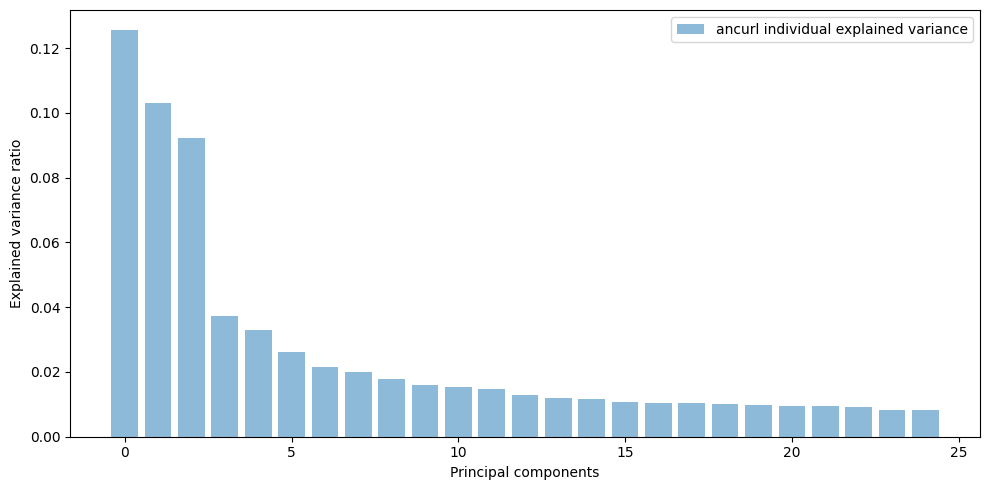

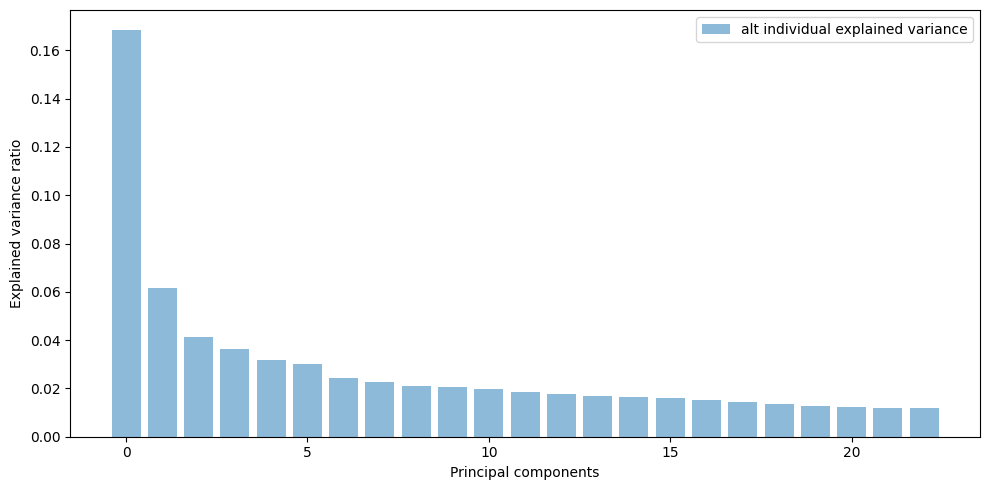

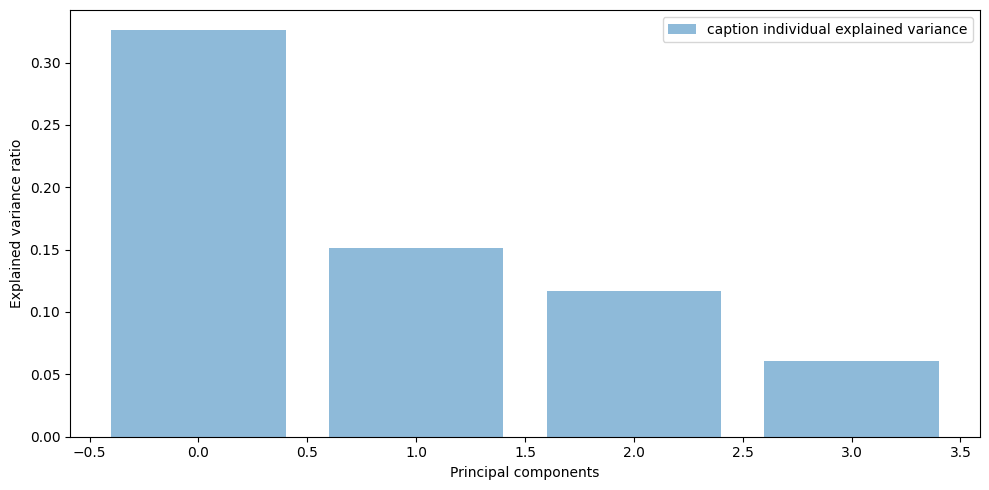

Numero di colonne ottenute:  107


In [36]:
pca_train_set, pca_test_set = apply_pca(train_set_reduced, test_set_reduced, n_components=0.65, show_plots=True)
print("Numero di colonne ottenute: ", len(pca_train_set.columns))

Grafico a barre Scree plot che mostra quanta varianza è spiegata da ciascuna componente principale. Si è ottenuta una sostanziale riduzione delle features.

# Valutazione della Separabilità delle Classi con LDA <a id="lda"></a>

L'Analisi Discriminante Lineare (Linear Discriminant Analysis, LDA) è una tecnica sia di riduzione della dimensionalità che di classificazione. In questo contesto, l'obiettivo principale dell'uso di LDA è valutare la separabilità lineare delle classi nel dataset. Questo passaggio è cruciale per comprendere come i diversi modelli di classificazione potrebbero comportarsi sul dataset.

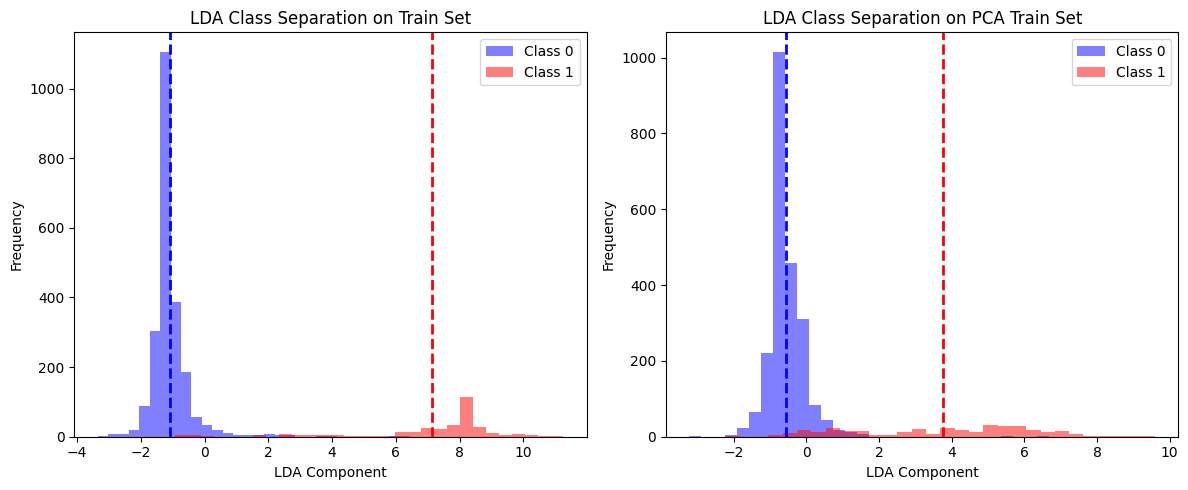

In [37]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

def plot_lda(ax, X, y, title):
    lda = LinearDiscriminantAnalysis()
    lda.fit(X, y)
    X_lda = lda.transform(X)
    
    ax.hist(X_lda[y == 0], bins=30, alpha=0.5, label='Class 0', color='blue')
    ax.hist(X_lda[y == 1], bins=30, alpha=0.5, label='Class 1', color='red')
    ax.axvline(X_lda[y == 0].mean(), color='blue', linestyle='dashed', linewidth=2)
    ax.axvline(X_lda[y == 1].mean(), color='red', linestyle='dashed', linewidth=2)
    ax.set_xlabel('LDA Component')
    ax.set_ylabel('Frequency')
    ax.set_title(title)
    ax.legend()

# Plot LDA for train_set_reduced
X_train = train_set_reduced.drop('Class', axis=1) 
y_train = train_set_reduced['Class'] 
plot_lda(axes[0], X_train, y_train, 'LDA Class Separation on Train Set')

# Plot LDA for pca_set_reduced
X_pca = pca_train_set.drop('Class', axis=1)  
y_pca = pca_train_set['Class']
plot_lda(axes[1], X_pca, y_pca, 'LDA Class Separation on PCA Train Set')

plt.tight_layout()
plt.show()

Sebbene vi sia una certa sovrapposizione tra gli istogrammi delle due classi, le **linee tratteggiate indicanti le medie** dei valori della proiezione LDA sono relativamente distanti l'una dall'altra. Questo suggerisce che, nonostante una certa ambiguità, le classi sono in gran parte linearmente separabili.

Questi risultati suggeriscono che un modello di classificazione lineare potrebbe avere una buona performance sul dataset.

# Regressione e Classificazione <a id="regressione-e-classificazione"></a>

Nel prossimo capitolo, si esaminerà l'applicazione delle tecniche di regressione al dataset fornito. Si rende necessario utilizzare il dateset ottenuto tramite riduzione delle variabily dummy e quello ottenuto dall'analisi delle componenti principali (PCA), poiché il numero di variabili indipendenti nel dataset originale sarebbe eccessivo e richiederebbe tempi di calcolo proibitivi. Si verifica facilmente l'errore di 'maximum recursion depth exceeded'.

Le prestazioni degli algoritmi saranno valutate in termini di Accuracy, Precision, Recall ed F1 score, verrà inoltre visualizzata la matrice di cofusione. Si definisce per lo scopo la seguente funzione:

In [38]:
classes = ["noadv",  "adv"]
def print_metrics(Y_train, pred_train, Y_test, pred_test):
    fig, axs = plt.subplots(2, 2, figsize=(13,13))

    for idx, (Y, pred, title) in enumerate(zip([Y_train, Y_test], [pred_train, pred_test], ["Train Confusion Matrix", "Test Confusion Matrix"])):
        cf_matrix = confusion_matrix(Y, pred)
        sns.heatmap(cf_matrix, annot=True, fmt='g', xticklabels=classes, cmap='cividis',
                    yticklabels=classes, ax=axs[0, idx]).set_title(title)
        
        metrics = ["Precision", "Recall", "F1 Score", "Accuracy"]
        results = [precision_score(Y, pred), 
                   recall_score(Y, pred), 
                   f1_score(Y, pred),
                   accuracy_score(Y, pred)]
        
        g = sns.barplot(x=metrics, y=results, ax=axs[1, idx])
        g.set_yticks(np.arange(0, 1.01, 0.05))
        
    print("Train Accuracy: ", accuracy_score(Y_train, pred_train))
    print("Test Accuracy: ", accuracy_score(Y_test, pred_test))

La matrice di confusione è presentata secondo la convenzione standard utilizzata da scikit-learn:

- La prima riga contiene i "True Negatives (TN)" e i "False Positives (FP)".
- La seconda riga contiene i "False Negatives (FN)" e i "True Positives (TP)".

## Regressione Logistica <a id="reg-logistica"></a>

Si definiscono le seguenti funzioni ausiliarie atte ad implementare la backward feature elimination.

In [39]:
def backward_elimination_logistic(train_data, target_variable, regularization=None):
    feature_string = '+'.join([feature for feature in train_data.columns if feature != target_variable])
    formula = target_variable + " ~ " + feature_string
    if regularization is not None:
        regression_model = logit(formula, train_data).fit_regularized(alpha=1.0, L1_wt=0.0 if regularization=='l1' else 1.0, disp=0)
    else:
        regression_model = logit(formula, train_data).fit(disp=0)          
    print("Pseudo R-squ.:", regression_model.prsquared)
    
    eliminated_features = []
    x_vars = feature_string.split("+")

    while regression_model.pvalues.drop("Intercept").max() > 0.1:
        feature_to_remove = regression_model.pvalues.drop("Intercept").idxmax()
        eliminated_features.append(feature_to_remove)
        x_vars.remove(feature_to_remove)
        # print("feature_to_remove: ", feature_to_remove)
        # print("value: ", regression_model.pvalues.drop("Intercept").max())
        # print("new x_vars: ", x_vars)
        # print()
        formula = target_variable + " ~ " + '+'.join(x_vars)
        if regularization is not None:
            regression_model = logit(formula, train_data).fit_regularized(alpha=1.0, L1_wt=0.0 if regularization=='ridge' else 1.0, disp=0)
        else:
            regression_model = logit(formula, train_data).fit(disp=0)    
    
    return regression_model, eliminated_features

def perform_logistic_regression(train_data, dependent_variable, regularization=None):
    regression_model, eliminated_features = backward_elimination_logistic(train_data, dependent_variable, regularization=regularization)
    print("Eliminated features: ", eliminated_features)
    print("Len: ", len(eliminated_features))
    print(regression_model.summary())
    
    return regression_model


### Baseline <a id="baseline"></a>

In [65]:
def replace_special_chars(column_name):
    mapping = {
        '.': '_dot_',
        '+': '_plus_',
        '®': '_registered_',
        '-': '_minus_',
        '*': '_asterisk_'
    }
    for special_char, replacement in mapping.items():
        column_name = column_name.replace(special_char, replacement)
    return column_name

# Sostituzione dei caratteri speciali nei nomi delle colonne
train_data = train_set_reduced.copy()
train_data.columns = [replace_special_chars(col) for col in train_data.columns]

target_variable = "Class"
feature_string = '+'.join([feature for feature in train_data.columns if feature != target_variable])
formula = target_variable + " ~ " + feature_string
baseline_model = logit(formula, train_data).fit()

/Users/danilosantitto/.local/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning:

overflow encountered in exp



         Current function value: inf
         Iterations: 35


/Users/danilosantitto/.local/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning:

divide by zero encountered in log



LinAlgError: Singular matrix

Una "matrice singolare" è una matrice che non ha un'inversa. Nel contesto della regressione, la matrice $X$ è utilizzata per calcolare la matrice delle covarianze $X'X$, e successivamente la sua inversa è utilizzata per stimare i coefficienti del modello. Se $X'X$ è singolare (o quasi singolare, cioè mal condizionata), allora non può essere invertita, rendendo impossibile o instabile la stima dei coefficienti.


La presenza di singolarità della matrice, riscontrata nell'esecuzione della regressione logistica, potrebbe essere attribuita alla natura sparsa del dataset utilizzato. La prevalenza di valori nulli nelle variabili dummy e la possibile alta correlazione tra di esse potrebbero causare varianza molto bassa e problemi di multicollinearità. Nonostante le strategie di riduzione delle dimensioni, la singolarità persiste, indicando una problematica probabilmente legata alla struttura intrinseca del dataset.

### Reg Logistica usando dataset ottenuto tramite PCA <a id="reg-pca"></a>

Di seguito viene applicata la backward features elimination sul dataset ottenuto tramite PCA.

In [272]:
pca_model = perform_logistic_regression(pca_train_set, dependent_variable="Class")

Pseudo R-squ.: 0.7647116129578057
Eliminated features:  ['ancurl_c15', 'origurl_c22', 'caption_c0', 'ancurl_c19', 'ancurl_c24', 'alt_c4', 'alt_c14', 'ancurl_c17', 'url_c14', 'origurl_c0', 'alt_c6', 'url_c13', 'url_c3', 'origurl_c25', 'caption_c1', 'url_c21', 'url_c23', 'ancurl_c18', 'ancurl_c2', 'origurl_c18', 'url_c12', 'origurl_c8', 'alt_c20', 'alt_c13', 'alt_c17', 'alt_c21', 'origurl_c9', 'origurl_c3', 'origurl_c10', 'ancurl_c12', 'ancurl_c9', 'url_c9', 'caption_c2', 'ancurl_c4', 'origurl_c4', 'origurl_c6', 'url_c18', 'ancurl_c16', 'aratio', 'alt_c19', 'alt_c12', 'ancurl_c22', 'origurl_c19', 'url_c19', 'url_c7', 'url_c20', 'origurl_c16', 'origurl_c23', 'ancurl_c20', 'local', 'caption_c3', 'url_c0', 'height', 'alt_c22', 'alt_c5', 'ancurl_c8', 'url_c8', 'url_c5', 'origurl_c1', 'origurl_c14', 'origurl_c2', 'url_c10']
Len:  62
                           Logit Regression Results                           
Dep. Variable:                  Class   No. Observations:                 2611
Mode

In [273]:
pca_model_lasso = perform_logistic_regression(pca_train_set, dependent_variable="Class", regularization='lasso')

/Users/danilosantitto/.local/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning:

overflow encountered in exp

/Users/danilosantitto/.local/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning:

divide by zero encountered in log



Pseudo R-squ.: 0.5816184075534557


/Users/danilosantitto/.local/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning:

overflow encountered in exp

/Users/danilosantitto/.local/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning:

divide by zero encountered in log

/Users/danilosantitto/.local/lib/python3.11/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning:

QC check did not pass for 1 out of 106 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers

/Users/danilosantitto/.local/lib/python3.11/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning:

Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.

/Users/danilosantitto/.local/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning:

overflow encountered in exp

/Users/danilosantitto/.local/lib/python3.11/site

Eliminated features:  ['caption_c2', 'url_c9', 'url_c5', 'url_c8', 'alt_c7', 'origurl_c17', 'url_c21', 'url_c12', 'origurl_c23', 'url_c15', 'origurl_c7', 'alt_c10', 'alt_c5', 'ancurl_c9', 'origurl_c0', 'alt_c4', 'origurl_c6', 'ancurl_c23', 'url_c16', 'ancurl_c18', 'url_c19', 'origurl_c1', 'url_c18', 'origurl_c5', 'alt_c3', 'url_c20', 'alt_c9', 'origurl_c13', 'origurl_c15', 'origurl_c16', 'ancurl_c24', 'ancurl_c14', 'url_c23', 'alt_c17', 'alt_c21', 'origurl_c11', 'url_c0', 'origurl_c4', 'url_c17', 'origurl_c8', 'origurl_c10', 'origurl_c18', 'origurl_c12', 'origurl_c25', 'origurl_c9', 'url_c11', 'origurl_c14', 'url_c6', 'ancurl_c7', 'ancurl_c15', 'ancurl_c13', 'origurl_c22', 'origurl_c20', 'local', 'origurl_c3', 'ancurl_c8', 'ancurl_c2', 'ancurl_c4', 'url_c1', 'origurl_c2', 'aratio', 'height', 'url_c7', 'alt_c16', 'url_c22', 'ancurl_c16', 'ancurl_c17', 'ancurl_c19', 'ancurl_c20', 'ancurl_c22']
Len:  70
                           Logit Regression Results                           
Dep. Va

### Valutazione PCA

Train Accuracy:  0.9724243584833397
Test Accuracy:  0.9464668094218416


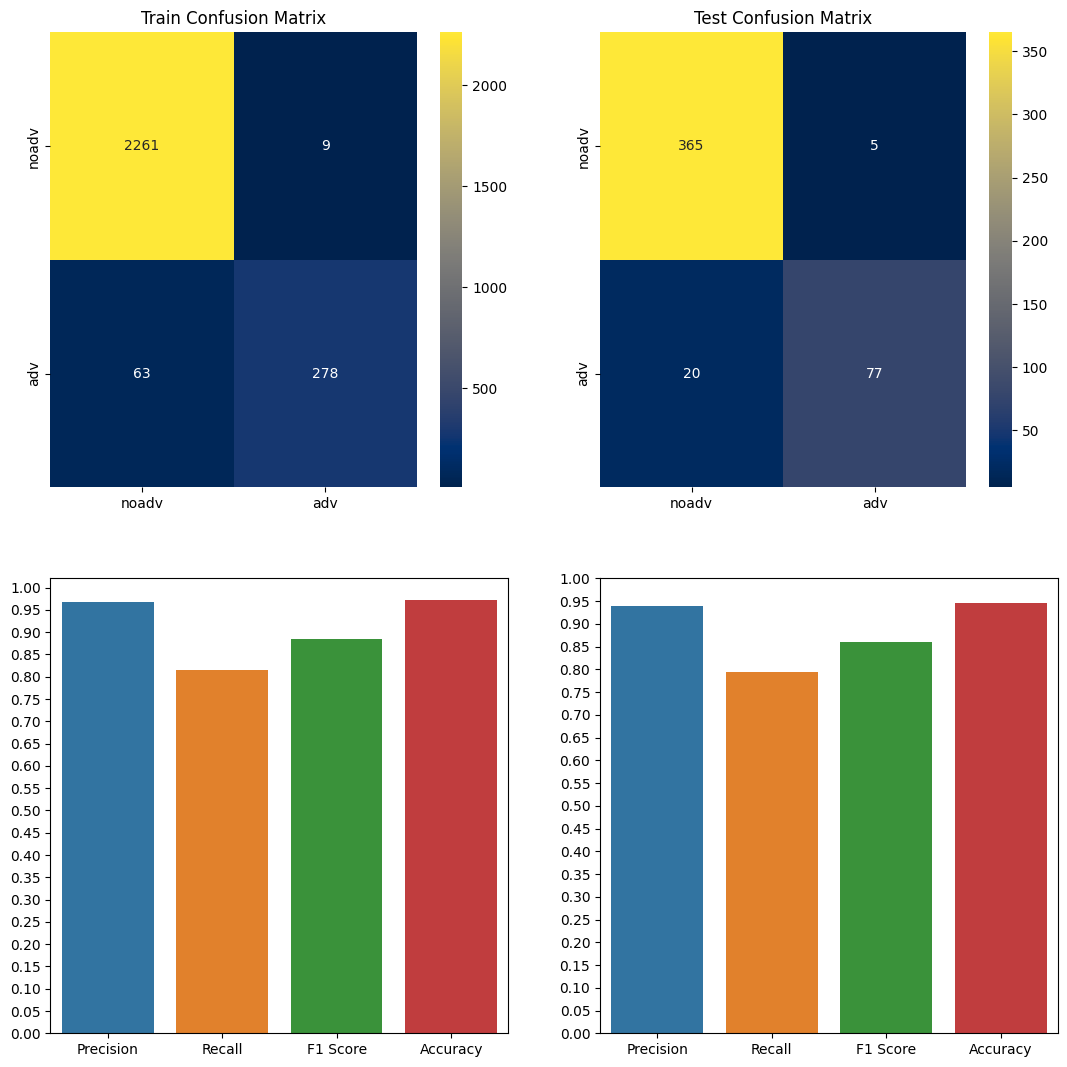

In [274]:
train_probs = pca_model.predict(pca_train_set)
train_pred = train_probs.round().astype(int)

test_probs = pca_model.predict(pca_test_set)
test_pred = test_probs.round().astype(int)

print_metrics(pca_train_set['Class'], train_pred, pca_test_set['Class'], test_pred)

Si noti che sia nel train che nel test set il modello ha una accuracy elavata. Si ha una precisione elevata e una recall più bassa, ciò indica che il modello in questo caso ha una risposta più perdonante, ovvero alcuni adv vengono erroneamente indicati come noadv, ovvero FN > FP. E' un comportamento effettivamente atteso in quanto il dataset risulta sbilanciato verso noadv, come prima analizzato nella sezione analisi precedente.

Train Accuracy:  0.9651474530831099
Test Accuracy:  0.9486081370449678


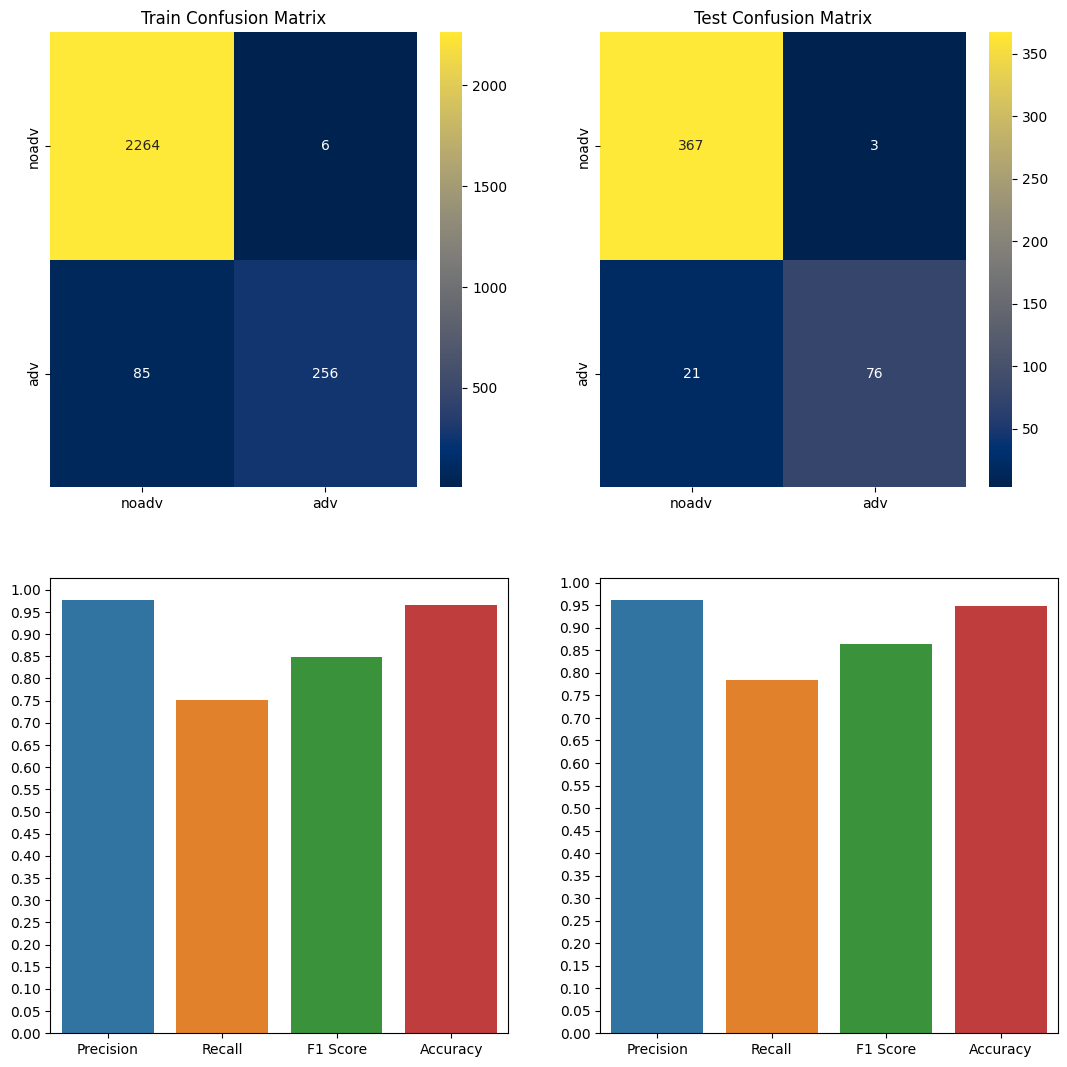

In [275]:
train_probs = pca_model_lasso.predict(pca_train_set)
train_pred = train_probs.round().astype(int)

test_probs = pca_model_lasso.predict(pca_test_set)
test_pred = test_probs.round().astype(int)

print_metrics(pca_train_set['Class'], train_pred, pca_test_set['Class'], test_pred)

La Lasso regolarization ha portato un miglioramento marginale e non significativo al task di classificazione.

## Bilanciamento del dataset di training <a id="bilanciamento-dataset"></a>

Per risolvere il bilanciamento del training set vengono attuate due principali metodologie:
- Undersampling: viene campionato dalla classe dominante un numero di campioni pari al numero della classe minoritaria.
- SMOTE: Il bilanciamento del training set tramite SMOTE è una tecnica di oversampling che genera nuovi campioni sintetici della classe minoritaria per migliorare l'equilibrio delle classi nel set di addestramento.

### Undersampling <a id="undersampling"></a>

In [39]:
#creo un dataset con i dati della classe minoritaria
pca_train_set_under = pca_train_set[pca_train_set.Class==1].copy() 

#aggiungo al dataset un numero di record (scelti a caso) della classe maggioritaria pari a quello della classe minoritaria
pca_train_set_under = pd.concat([pca_train_set_under, pca_train_set[pca_train_set.Class==0].sample(n=len(pca_train_set[pca_train_set.Class==1])).copy()])

#creo un dataset con i dati della classe minoritaria
train_set_reduced_under = train_set_reduced[train_set_reduced.Class==1].copy() 

#aggiungo al dataset un numero di record (scelti a caso) della classe maggioritaria pari a quello della classe minoritaria
train_set_reduced_under = pd.concat([train_set_reduced_under, train_set_reduced[train_set_reduced.Class==0].sample(n=len(train_set_reduced[train_set_reduced.Class==1])).copy()])

In [48]:
pca_train_set_under.Class.value_counts()

Class
1    341
0    341
Name: count, dtype: int64

In [278]:
pca_model = perform_logistic_regression(pca_train_set_under, dependent_variable="Class", regularization='lasso')

/Users/danilosantitto/.local/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning:

overflow encountered in exp

/Users/danilosantitto/.local/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning:

divide by zero encountered in log

/Users/danilosantitto/.local/lib/python3.11/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning:

QC check did not pass for 1 out of 107 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers

/Users/danilosantitto/.local/lib/python3.11/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning:

Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.



Pseudo R-squ.: 0.7309640782044102


/Users/danilosantitto/.local/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning:

overflow encountered in exp

/Users/danilosantitto/.local/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning:

divide by zero encountered in log

/Users/danilosantitto/.local/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning:

overflow encountered in exp

/Users/danilosantitto/.local/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning:

divide by zero encountered in log

/Users/danilosantitto/.local/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning:

overflow encountered in exp

/Users/danilosantitto/.local/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning:

divide by zero encountered in log

/Users/danilosantitto/.local/lib/python3.11/site-packages/statsmodels/discrete/discrete_

Eliminated features:  ['url_c0', 'ancurl_c21', 'alt_c7', 'ancurl_c5', 'caption_c0', 'alt_c16', 'url_c13', 'ancurl_c10', 'ancurl_c14', 'caption_c2', 'alt_c17', 'origurl_c13', 'origurl_c2', 'origurl_c4', 'origurl_c14', 'alt_c18', 'url_c10', 'origurl_c6', 'origurl_c19', 'origurl_c21', 'url_c5', 'origurl_c17', 'origurl_c24', 'url_c6', 'aratio', 'origurl_c10', 'height', 'ancurl_c9', 'alt_c1', 'origurl_c5', 'caption_c3', 'ancurl_c12', 'url_c15', 'url_c22', 'ancurl_c24', 'origurl_c9', 'ancurl_c4', 'local', 'ancurl_c17', 'alt_c9', 'url_c1', 'origurl_c15', 'origurl_c0']
Len:  43
                           Logit Regression Results                           
Dep. Variable:                  Class   No. Observations:                  682
Model:                          Logit   Df Residuals:                      668
Method:                           MLE   Df Model:                           13
Date:                Mon, 24 Jul 2023   Pseudo R-squ.:                  0.6866
Time:                       

Train Accuracy:  0.9306779011872846
Test Accuracy:  0.9400428265524625


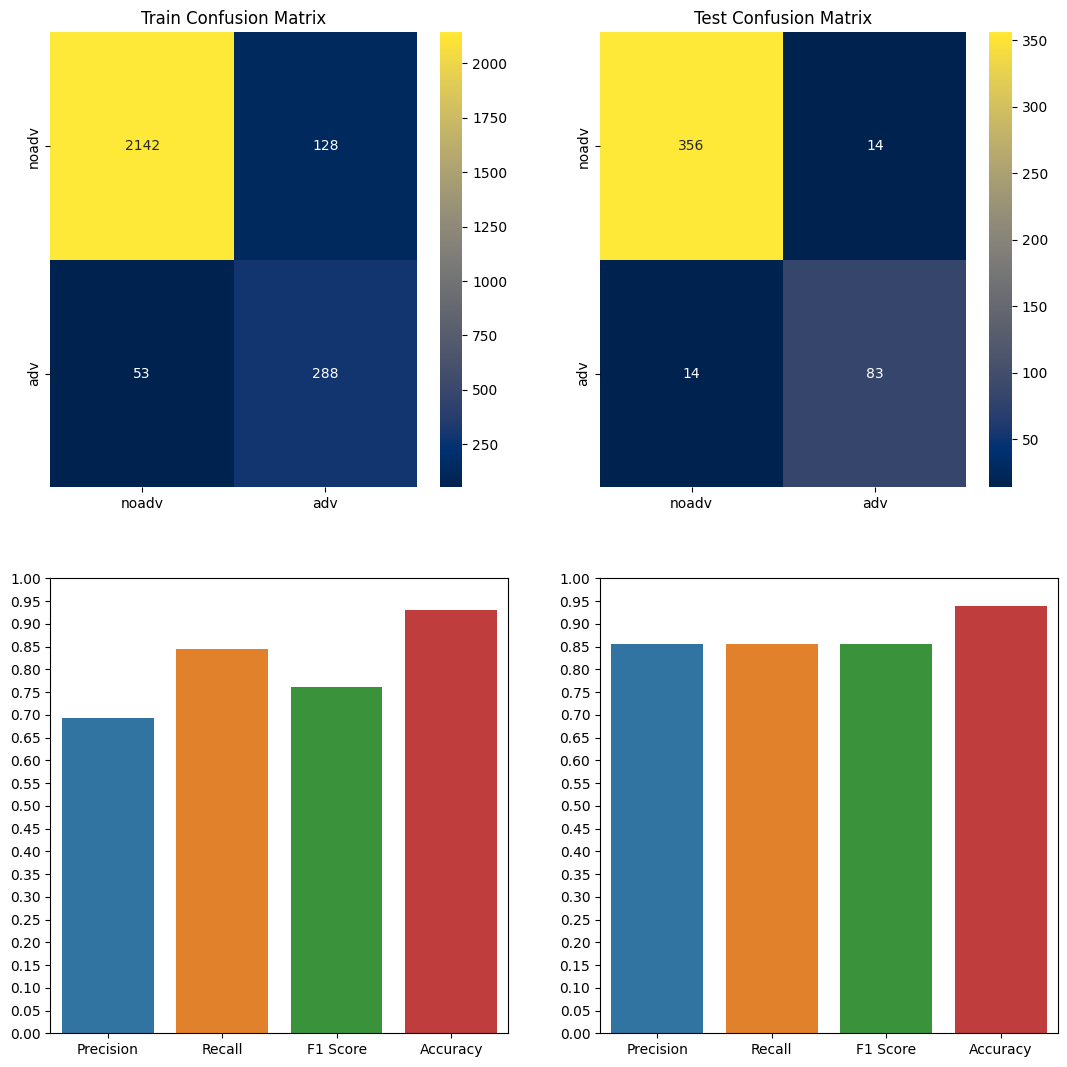

In [279]:
train_probs = pca_model.predict(pca_train_set)
train_pred = train_probs.round().astype(int)

test_probs = pca_model.predict(pca_test_set)
test_pred = test_probs.round().astype(int)

print_metrics(pca_train_set['Class'], train_pred, pca_test_set['Class'], test_pred)

Nel training set la situazione è cambiata, la precision è scesa, la recall è salita. Nel test set la situazione è invece migliorata, adesso il classificatore risulta equilibrato. Con una accuracy simile alla precedente.

### SMOTE <a id="smote"></a>

In [40]:
X_oversampled, y_oversampled = SMOTE(k_neighbors=5).fit_resample(pca_train_set.drop('Class', axis=1), pca_train_set.Class)
pca_train_set_oversampled = pd.concat([X_oversampled, y_oversampled.rename('Class')], axis=1)

X_oversampled, y_oversampled = SMOTE(k_neighbors=5).fit_resample(train_set_reduced.drop('Class', axis=1), train_set_reduced.Class)
train_set_reduced_oversampled = pd.concat([X_oversampled, y_oversampled.rename('Class')], axis=1)

In [281]:
pca_train_set_oversampled.Class.value_counts()

Class
1    2270
0    2270
Name: count, dtype: int64

In [282]:
pca_model = perform_logistic_regression(pca_train_set_oversampled, dependent_variable="Class", regularization='lasso')

/Users/danilosantitto/.local/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning:

overflow encountered in exp

/Users/danilosantitto/.local/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning:

divide by zero encountered in log



Pseudo R-squ.: 0.48120029939496756


/Users/danilosantitto/.local/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning:

overflow encountered in exp

/Users/danilosantitto/.local/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning:

divide by zero encountered in log

/Users/danilosantitto/.local/lib/python3.11/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning:

QC check did not pass for 1 out of 106 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers

/Users/danilosantitto/.local/lib/python3.11/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning:

Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.

/Users/danilosantitto/.local/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning:

overflow encountered in exp

/Users/danilosantitto/.local/lib/python3.11/site

Eliminated features:  ['ancurl_c2', 'url_c8', 'url_c9', 'ancurl_c13', 'url_c12', 'url_c21', 'ancurl_c9', 'url_c15', 'caption_c0', 'alt_c4', 'url_c5', 'origurl_c8', 'origurl_c9', 'url_c23', 'origurl_c14', 'origurl_c10', 'origurl_c3', 'alt_c22', 'origurl_c12', 'alt_c14', 'origurl_c20', 'origurl_c25', 'alt_c20', 'ancurl_c16', 'caption_c2', 'origurl_c16', 'url_c19', 'ancurl_c19', 'ancurl_c15', 'url_c20', 'origurl_c18', 'alt_c11', 'ancurl_c22', 'origurl_c11', 'alt_c3', 'alt_c13', 'alt_c15', 'alt_c6', 'ancurl_c8', 'url_c6', 'origurl_c23', 'origurl_c22', 'origurl_c1', 'origurl_c0', 'origurl_c17', 'ancurl_c23', 'ancurl_c17', 'alt_c7', 'ancurl_c20', 'ancurl_c6', 'url_c7', 'origurl_c5', 'url_c16', 'origurl_c13', 'url_c22', 'alt_c5', 'alt_c8', 'alt_c9', 'origurl_c6', 'ancurl_c4', 'caption_c1', 'alt_c21', 'url_c10']
Len:  63
                           Logit Regression Results                           
Dep. Variable:                  Class   No. Observations:                 4540
Model:           

/Users/danilosantitto/.local/lib/python3.11/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning:

QC check did not pass for 1 out of 44 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers

/Users/danilosantitto/.local/lib/python3.11/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning:

Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.



Train Accuracy:  0.9559555725775565
Test Accuracy:  0.9528907922912205


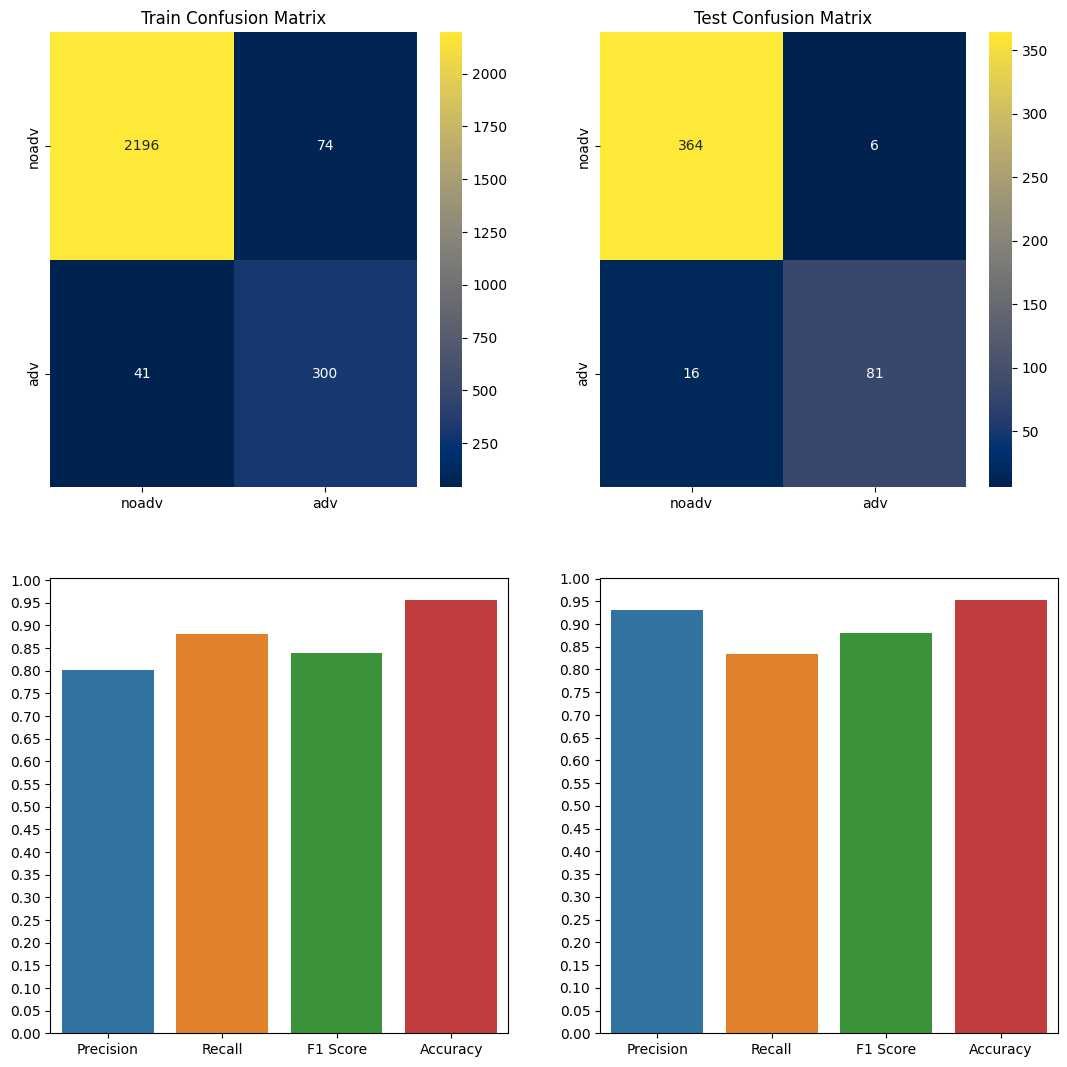

In [283]:
train_probs = pca_model.predict(pca_train_set)
train_pred = train_probs.round().astype(int)

test_probs = pca_model.predict(pca_test_set)
test_pred = test_probs.round().astype(int)

print_metrics(pca_train_set['Class'], train_pred, pca_test_set['Class'], test_pred)

L'accuracy con SMOTE non è cambiata rispetto a quella di base, il classificatore tende però ad essere più equilibrato.

# Support Vector Machine <a id="svm"></a>

Le Support Vector Machines (SVM) sono una categoria di algoritmi di apprendimento supervisionato utilizzati per la classificazione e la regressione. Questi modelli cercano di trovare l'iperpiano ottimale che massimizza il margine tra le classi nei dati di addestramento, offrendo così buone prestazioni in termini di generalizzazione.

Viene utilizzato il tool GridSearchCV di sklearn tramite il quale viene effettuata la cross-validation al fine di individuare il corretto valore per i parametri tra quelli dati in input.

Si noti che avendo ottenuto una buona separazione con LDA e un buon risultato con il regressore logistico, i dati sono opportunamente linearmente separabili. Si procede dunque ad usare GridSearchCV per determinare quale valore di C è ottimale. Il parametro C in SVM è un parametro di regolarizzazione che aiuta a controllare l'equilibrio tra la riduzione dell'errore di classificazione e la massimizzazione del margine. Valori grandi di C corrispondono ad un hard margin, valori piccoli di C permettono di accettare errori di classificazione e corrispondono ad un soft margin per SVM.

In [40]:
def get_grid_search(verbose=0):
    params = {
    'C': [0.01, 0.1, 1, 10], # soft or hard margin
    # 'gamma': [0.0001, 0.001, 0.01],  # for not linear kernel
    'kernel': ['linear']  # only 'linear' kernel ['linear', 'poly', 'rbf']
    }
    return GridSearchCV(SVC(), 
        params,
        verbose=verbose)

def train_svm_and_predict(train_dataset, test_dataset, **kwargs):
    svm = SVC(**kwargs)
    model = svm.fit(train_dataset.drop('Class', axis=1), train_dataset['Class'])

    train_pred = model.predict(train_dataset.drop('Class', axis=1))
    test_pred = model.predict(test_dataset.drop('Class', axis=1))
    
    print_metrics(train_dataset['Class'], train_pred, test_dataset['Class'], test_pred)

## Baseline <a id="baseline-svm"></a>

Notando i buoni risultati ottenuti nella regressione logistica, si usa il kernel linear.

In [40]:
grid_search = get_grid_search(verbose=3)
score = grid_search.fit(train_set_reduced.drop('Class', axis=1), train_set['Class'])
score.best_params_

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END .............C=0.01, kernel=linear;, score=0.945 total time=   0.8s
[CV 2/5] END .............C=0.01, kernel=linear;, score=0.944 total time=   1.0s
[CV 3/5] END .............C=0.01, kernel=linear;, score=0.946 total time=   1.0s
[CV 4/5] END .............C=0.01, kernel=linear;, score=0.943 total time=   1.1s
[CV 5/5] END .............C=0.01, kernel=linear;, score=0.948 total time=   1.1s
[CV 1/5] END ..............C=0.1, kernel=linear;, score=0.960 total time=   2.0s
[CV 2/5] END ..............C=0.1, kernel=linear;, score=0.958 total time=   1.9s
[CV 3/5] END ..............C=0.1, kernel=linear;, score=0.967 total time=   2.2s
[CV 4/5] END ..............C=0.1, kernel=linear;, score=0.969 total time=   2.5s
[CV 5/5] END ..............C=0.1, kernel=linear;, score=0.971 total time=   1.9s
[CV 1/5] END ................C=1, kernel=linear;, score=0.967 total time=   4.2s
[CV 2/5] END ................C=1, kernel=linear;,

{'C': 1, 'kernel': 'linear'}

Train Accuracy:  0.9862121792416698
Test Accuracy:  0.974304068522484


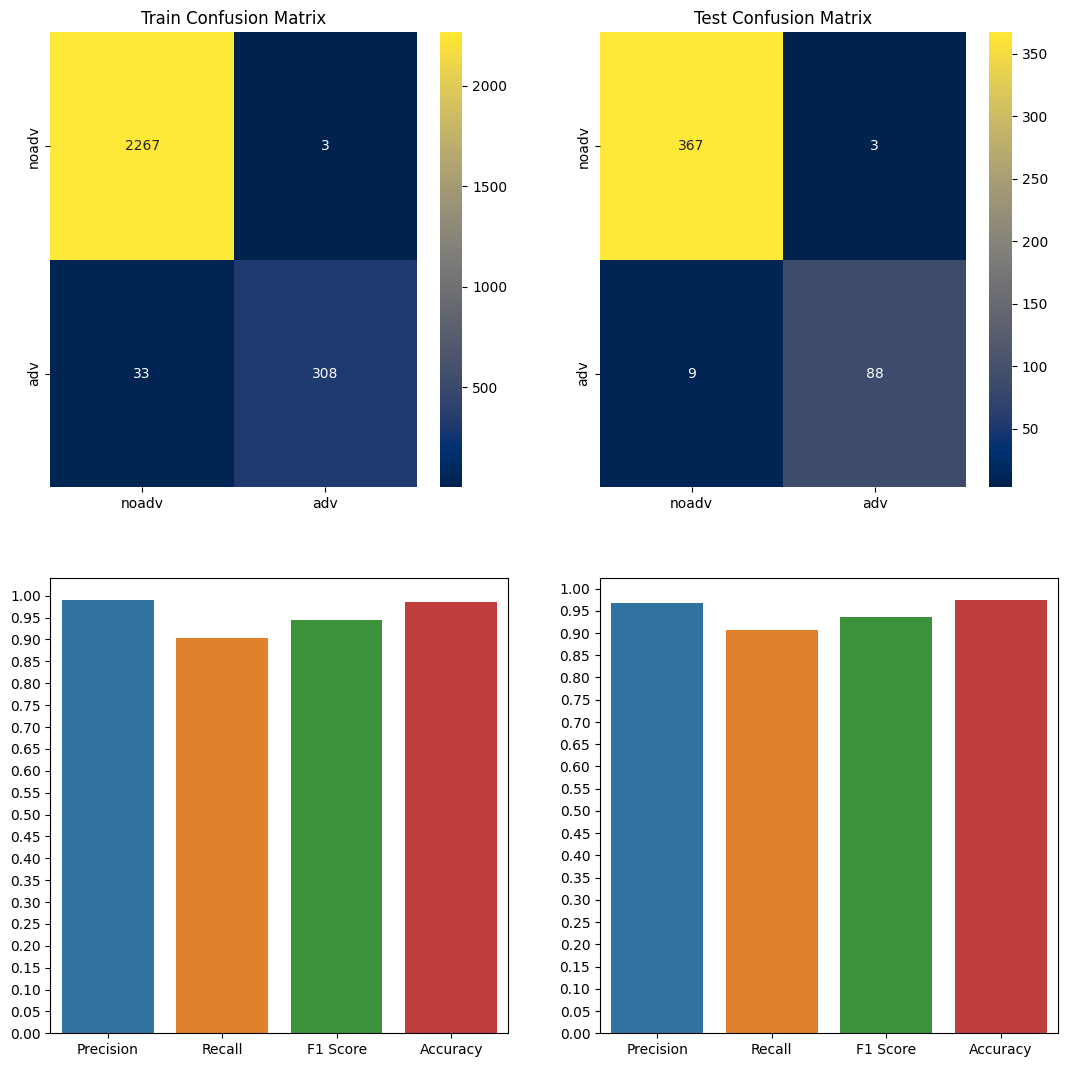

In [43]:
train_svm_and_predict(train_set_reduced, test_set_reduced, kernel ='linear', C=1)

Si è ottenuto un buon risultato sul test set. Si noti come nonostante il dataset sia fortemente sbilanciato, svm riesce a gestire questo caso, ottenendo comunque FN > FP che tende ad abbassare la recall. Si testi ora sul dataset bilanciato.

Train Accuracy:  0.9444933920704845
Test Accuracy:  0.9186295503211992


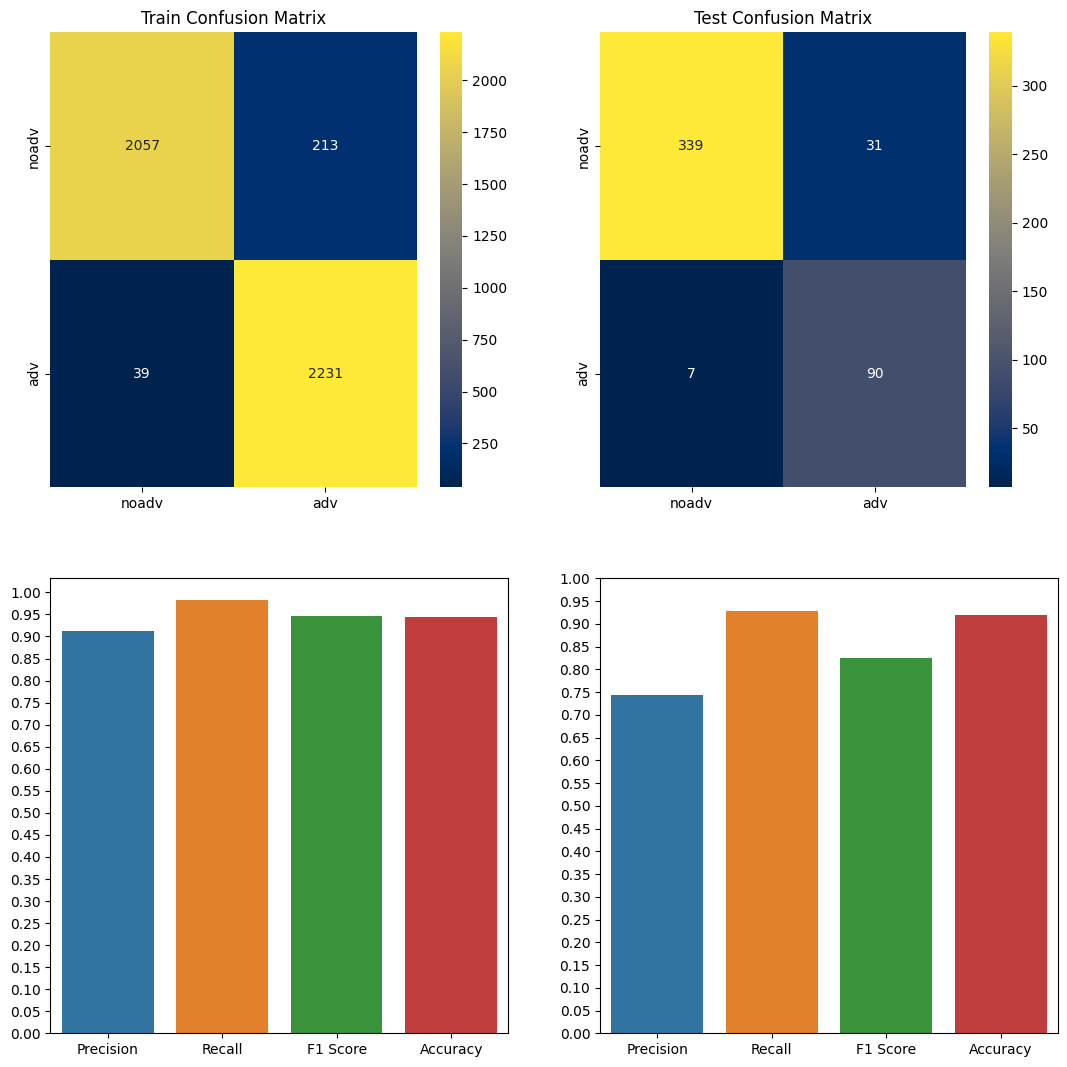

In [41]:
train_svm_and_predict(train_set_reduced_oversampled, test_set_reduced, kernel ='linear', C=1)

Con la versione oversampled, il classificatore è diventato "sospettoso" in quanto compie molti errori classificando noadv come adv.

## PCA <a id="pca-svm"></a>

In [287]:
grid_search = get_grid_search()
score = grid_search.fit(pca_train_set.drop('Class', axis=1), pca_train_set['Class'])
score.best_params_

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[CV 1/5] END .............C=0.01, kernel=linear;, score=0.946 total time=   0.3s
[CV 2/5] END .............C=0.01, kernel=linear;, score=0.939 total time=   0.3s
[CV 3/5] END .............C=0.01, kernel=linear;, score=0.937 total time=   0.4s
[CV 4/5] END .............C=0.01, kernel=linear;, score=0.937 total time=   0.4s
[CV 5/5] END .............C=0.01, kernel=linear;, score=0.939 total time=   0.4s
[CV 1/5] END ..............C=0.1, kernel=linear;, score=0.956 total time=   1.3s
[CV 2/5] END ..............C=0.1, kernel=linear;, score=0.956 total time=   0.8s
[CV 3/5] END ..............C=0.1, kernel=linear;, score=0.960 total time=   1.1s
[CV 4/5] END ..............C=0.1, kernel=linear;, score=0.967 total time=   0.9s
[CV 5/5] END ..............C=0.1, kernel=linear;, score=0.962 total time=   0.7s
[CV 1/5] END ................C=1, kernel=linear;, score=0.967 total time=   3.2s
[CV 2/5] END ................C=1, kernel=linear;, score=0.962 total time=   3.6s
[CV 3/5] END ...............

{'C': 1, 'kernel': 'linear'}

Train Accuracy:  0.9735733435465339
Test Accuracy:  0.9507494646680942


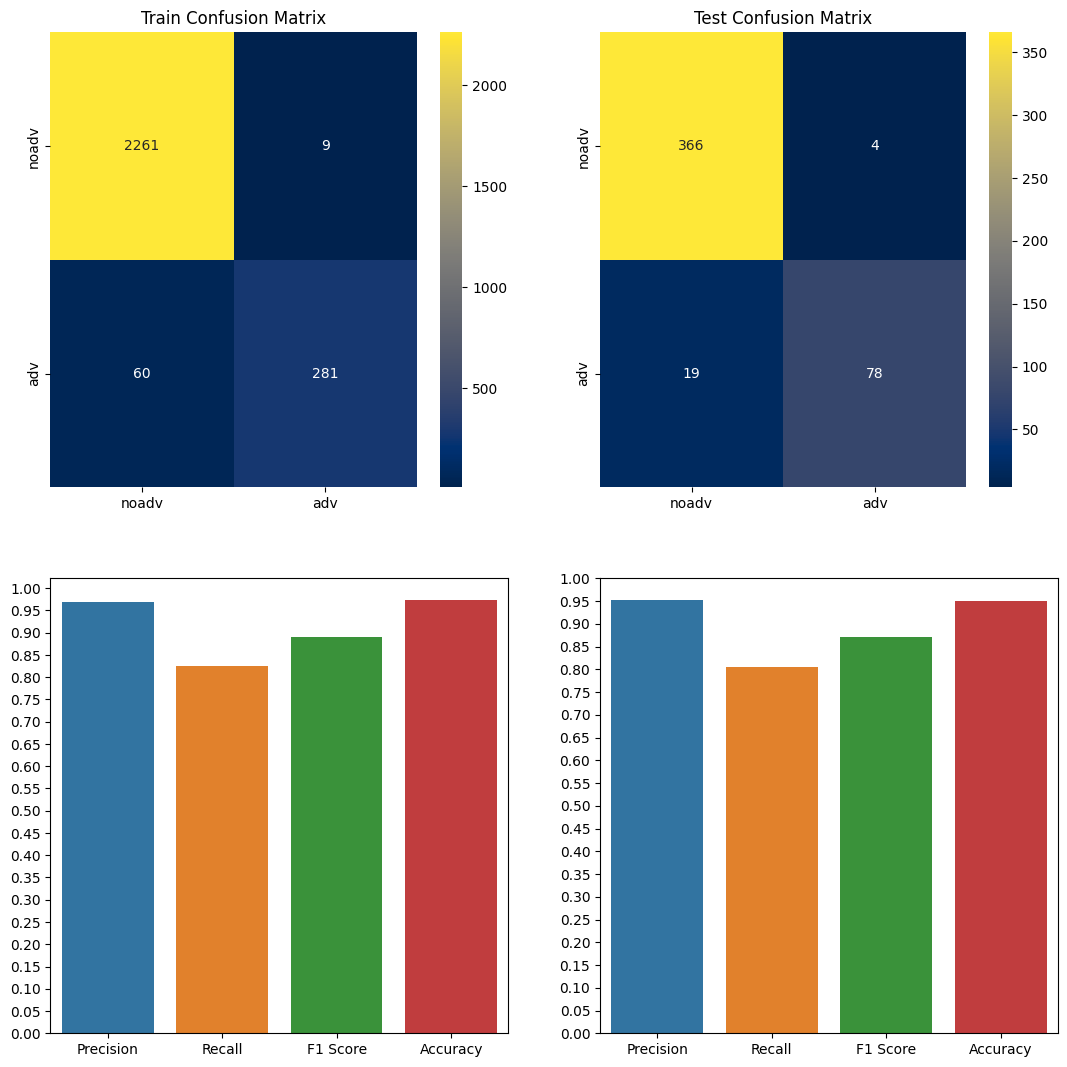

In [44]:
train_svm_and_predict(pca_train_set, pca_test_set, kernel ='linear', C=1)

Il modello dei dati con pca risente del forte sbilanciamento del dataset. Si testa SVC con il dataset a cui è stato applicato undersampling:

Train Accuracy:  0.9457478005865103
Test Accuracy:  0.9293361884368309


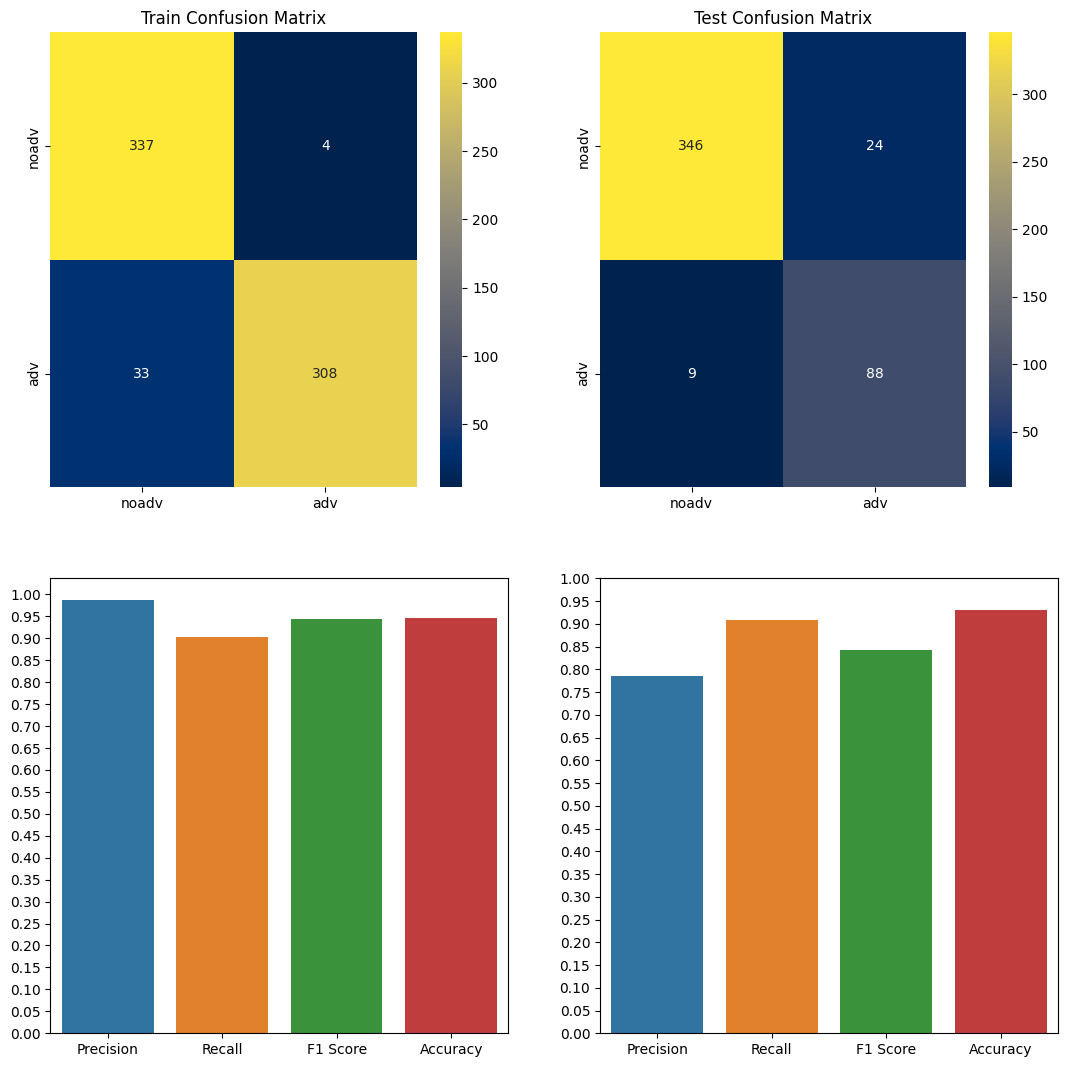

In [289]:
train_svm_and_predict(pca_train_set_under, pca_test_set, kernel ='linear', C=1)

Si ottiene una accuracy più bassa del caso precedente ed un classificatore più sospettoso in quanto FP > FN. Si testa con SMOTE:

Train Accuracy:  0.9513215859030837
Test Accuracy:  0.9571734475374732


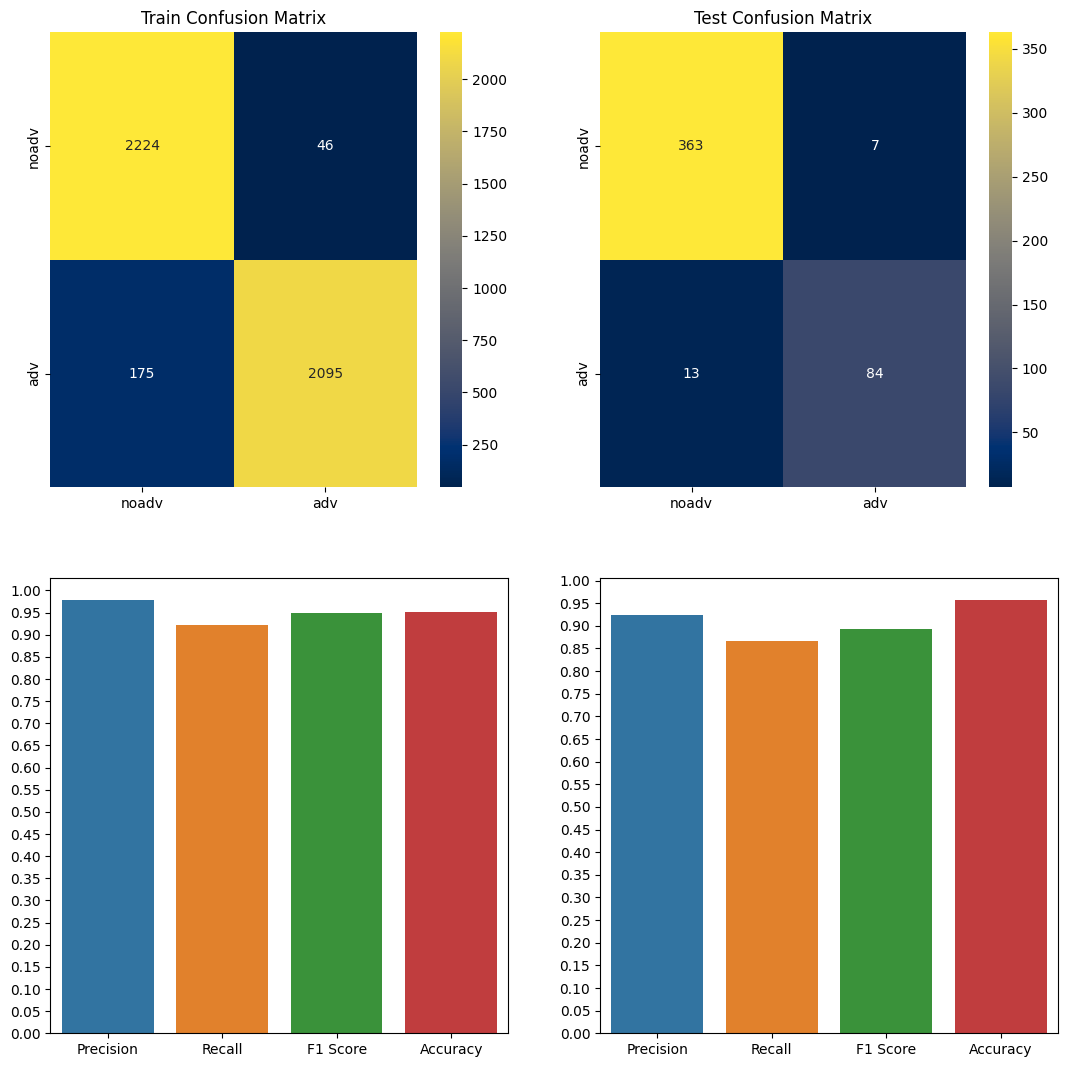

In [290]:
train_svm_and_predict(pca_train_set_oversampled, pca_test_set, kernel ='linear', C=1)

Utilizzando pca_train_oversampled tramite SMOTE, sul test set si ottiene un classificatore più equilibrato.

# Alberi Decisionali <a id="alberi">

Gli alberi decisionali sono algoritmi di apprendimento supervisionato usati sia per la classificazione che per la regressione. Creano un modello che predice il valore di una variabile target suddividendo le variabili di input in semplici regole decisionali. 

Durante la costruzione dell'albero, l'indice di Gini è spesso utilizzato per misurare l'impurità di un nodo e determinare il punto di divisione ottimale. La struttura dell'albero decisionale è intuitiva e facile da interpretare, poiché può essere visualizzata come un flusso di decisioni che porta a un risultato. La natura binaria di molte delle feature di questo dataset rendono interessante il loro utilizzo per il task di classificazione.

Di seguito si definiscono delle funzioni ausiliarie:

In [66]:
def print_metrics_no_plot(Y_train, pred_train, Y_test, pred_test):
    for (Y, pred, title) in zip([Y_train, Y_test], [pred_train, pred_test], ["Train", "Test"]):
        print(title + " Metrics:")
        print("Precision: ", precision_score(Y, pred))
        print("Recall: ", recall_score(Y, pred))
        print("F1 Score: ", f1_score(Y, pred))
        print("Accuracy: ", accuracy_score(Y, pred))
        print()

def print_dt(dt, train_set):
    train_data = train_set.copy()

    # Converte i valori nella colonna "Class" da 0 e 1 a 'noadv' e 'adv' rispettivamente (richiesto dalla libreria)
    train_data.loc[train_data["Class"] == 0, "Class"] = 'noadv'
    train_data.loc[train_data["Class"] == 1, "Class"] = 'adv'

    # Esporta l'albero di decisione in formato Graphviz
    dot_data = tree.export_graphviz(dt, out_file=None,feature_names=train_data.columns[:-1],
                                    class_names=['noadv', 'adv'], rotate=False, label='root')

    # Crea un grafico da dot_data
    return graphviz.Source(dot_data)

def train_dt(train_dataset, test_dataset, plot=False, **kwargs):
    dt = DecisionTreeClassifier(**kwargs)
    dt.fit(train_dataset.drop('Class',axis=1),train_dataset['Class'])
    pred=dt.predict(train_dataset.drop('Class',axis=1))
    test_pred=dt.predict(test_dataset.drop('Class',axis=1))
    print("Depth: ", dt.get_depth())
    if plot:
        print_metrics(train_dataset['Class'],pred,test_dataset['Class'],test_pred)
        return dt
    print_metrics_no_plot(train_dataset['Class'],pred,test_dataset['Class'],test_pred)
    return dt

## Baseline <a id="baseline-dt"></a>

Depth:  90
Train Accuracy:  0.9977020298736117
Test Accuracy:  0.9657387580299786


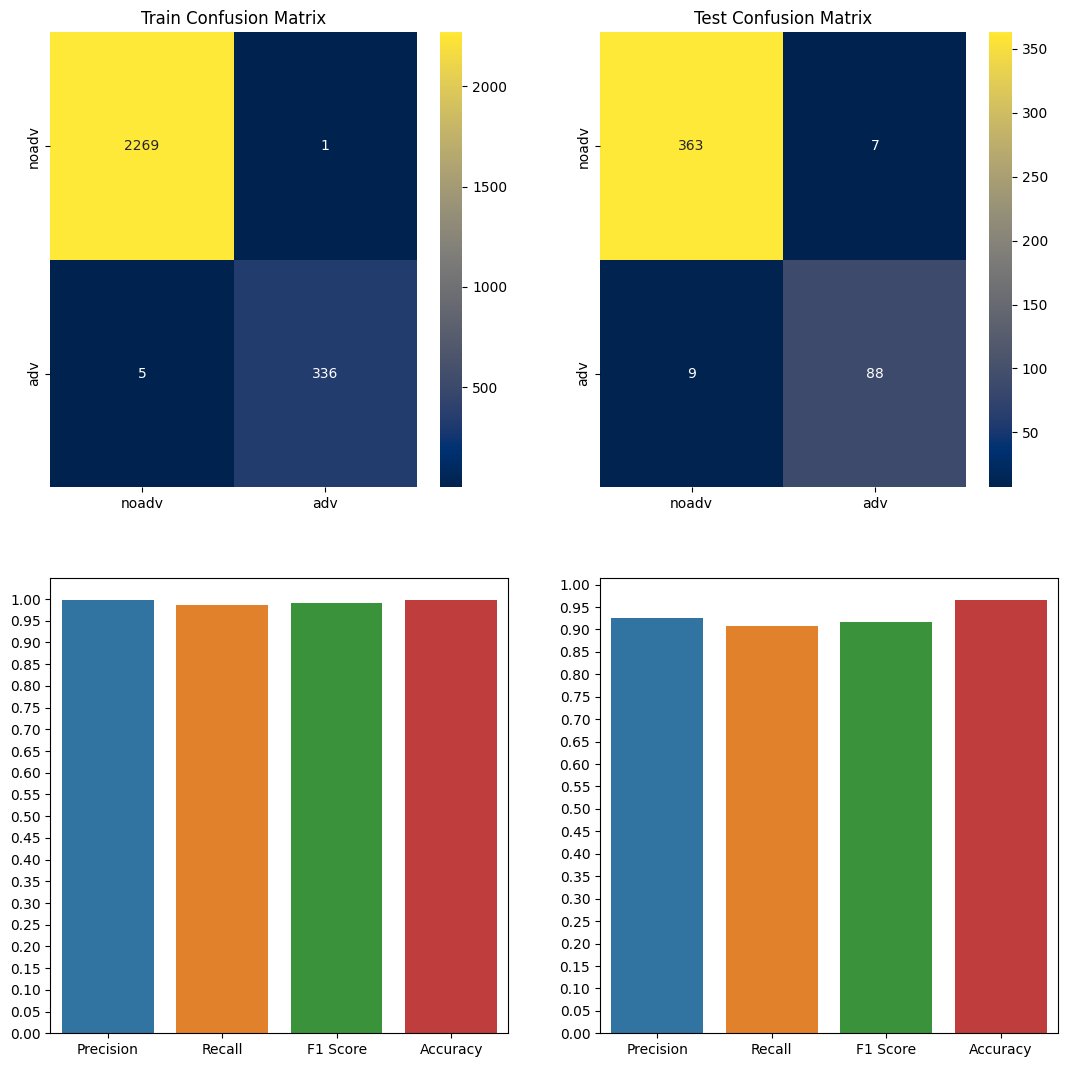

In [45]:
dt = train_dt(train_set_reduced, test_set_reduced, plot=True)

La profondità dell'albero di 90 potrebbe essere un indizio che l'albero ha appreso dettagli molto specifici dei dati di training che potrebbero non essere generalizzabili. Si rileva un leggero overfit del modello sul train set. Si prova ad applicare una procedura di pruning, selezionando l'iperparametro tramite cross-validation con GridSearchCV:

In [46]:
gr_dt_prune = GridSearchCV(DecisionTreeClassifier(), { 'ccp_alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10] })
gr_dt_prune.fit(train_set_reduced.drop('Class',axis=1), train_set_reduced['Class'])
gr_dt_prune.best_params_

{'ccp_alpha': 0.001}

Depth:  17
Train Accuracy:  0.9774032937571812
Test Accuracy:  0.9700214132762313


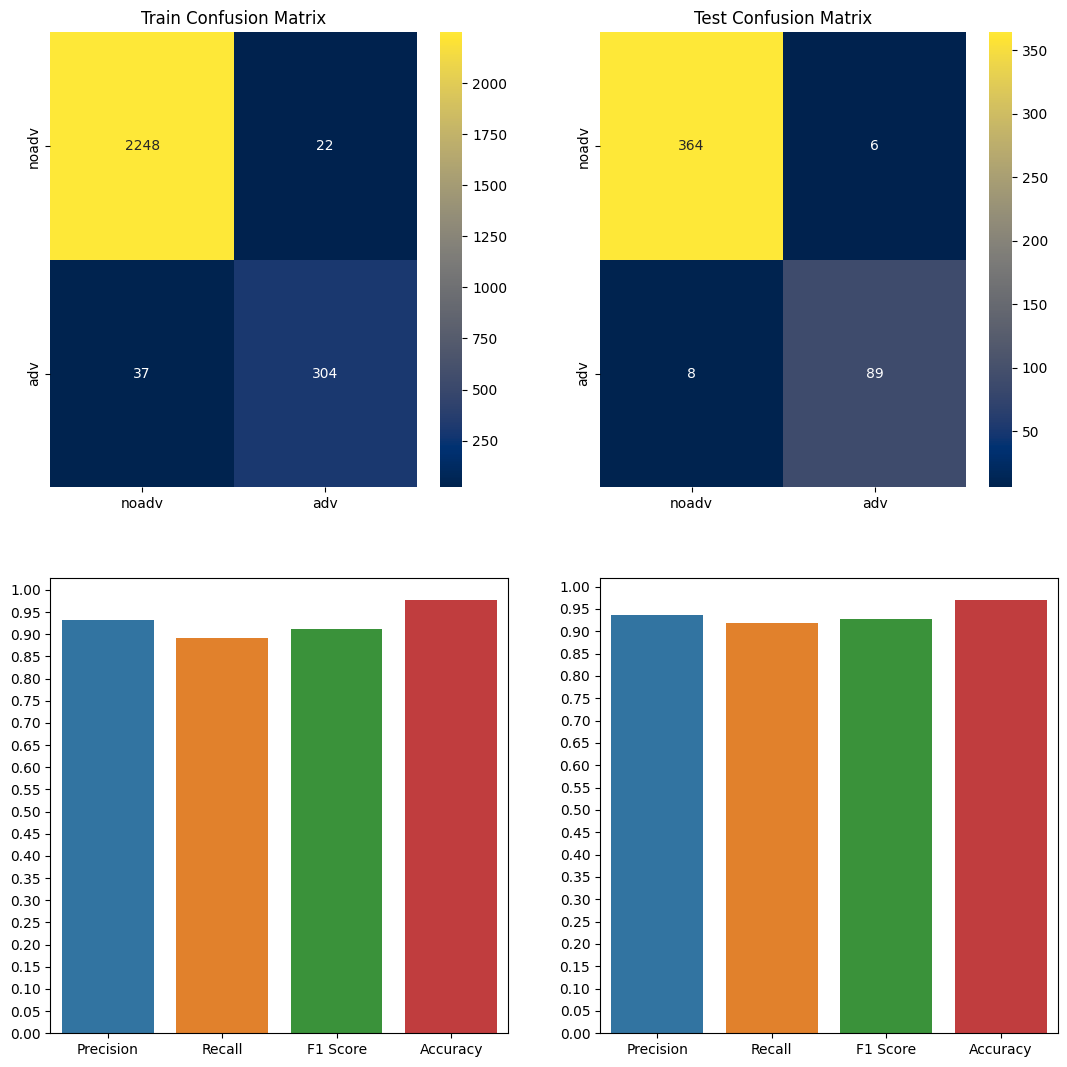

In [41]:
dt_prune = train_dt(train_set_reduced, test_set_reduced, plot=True, ccp_alpha=0.001)

Il pruning ha ridotto la depth da 90 a 17. Di seguito la visualizzazione dell'albero.

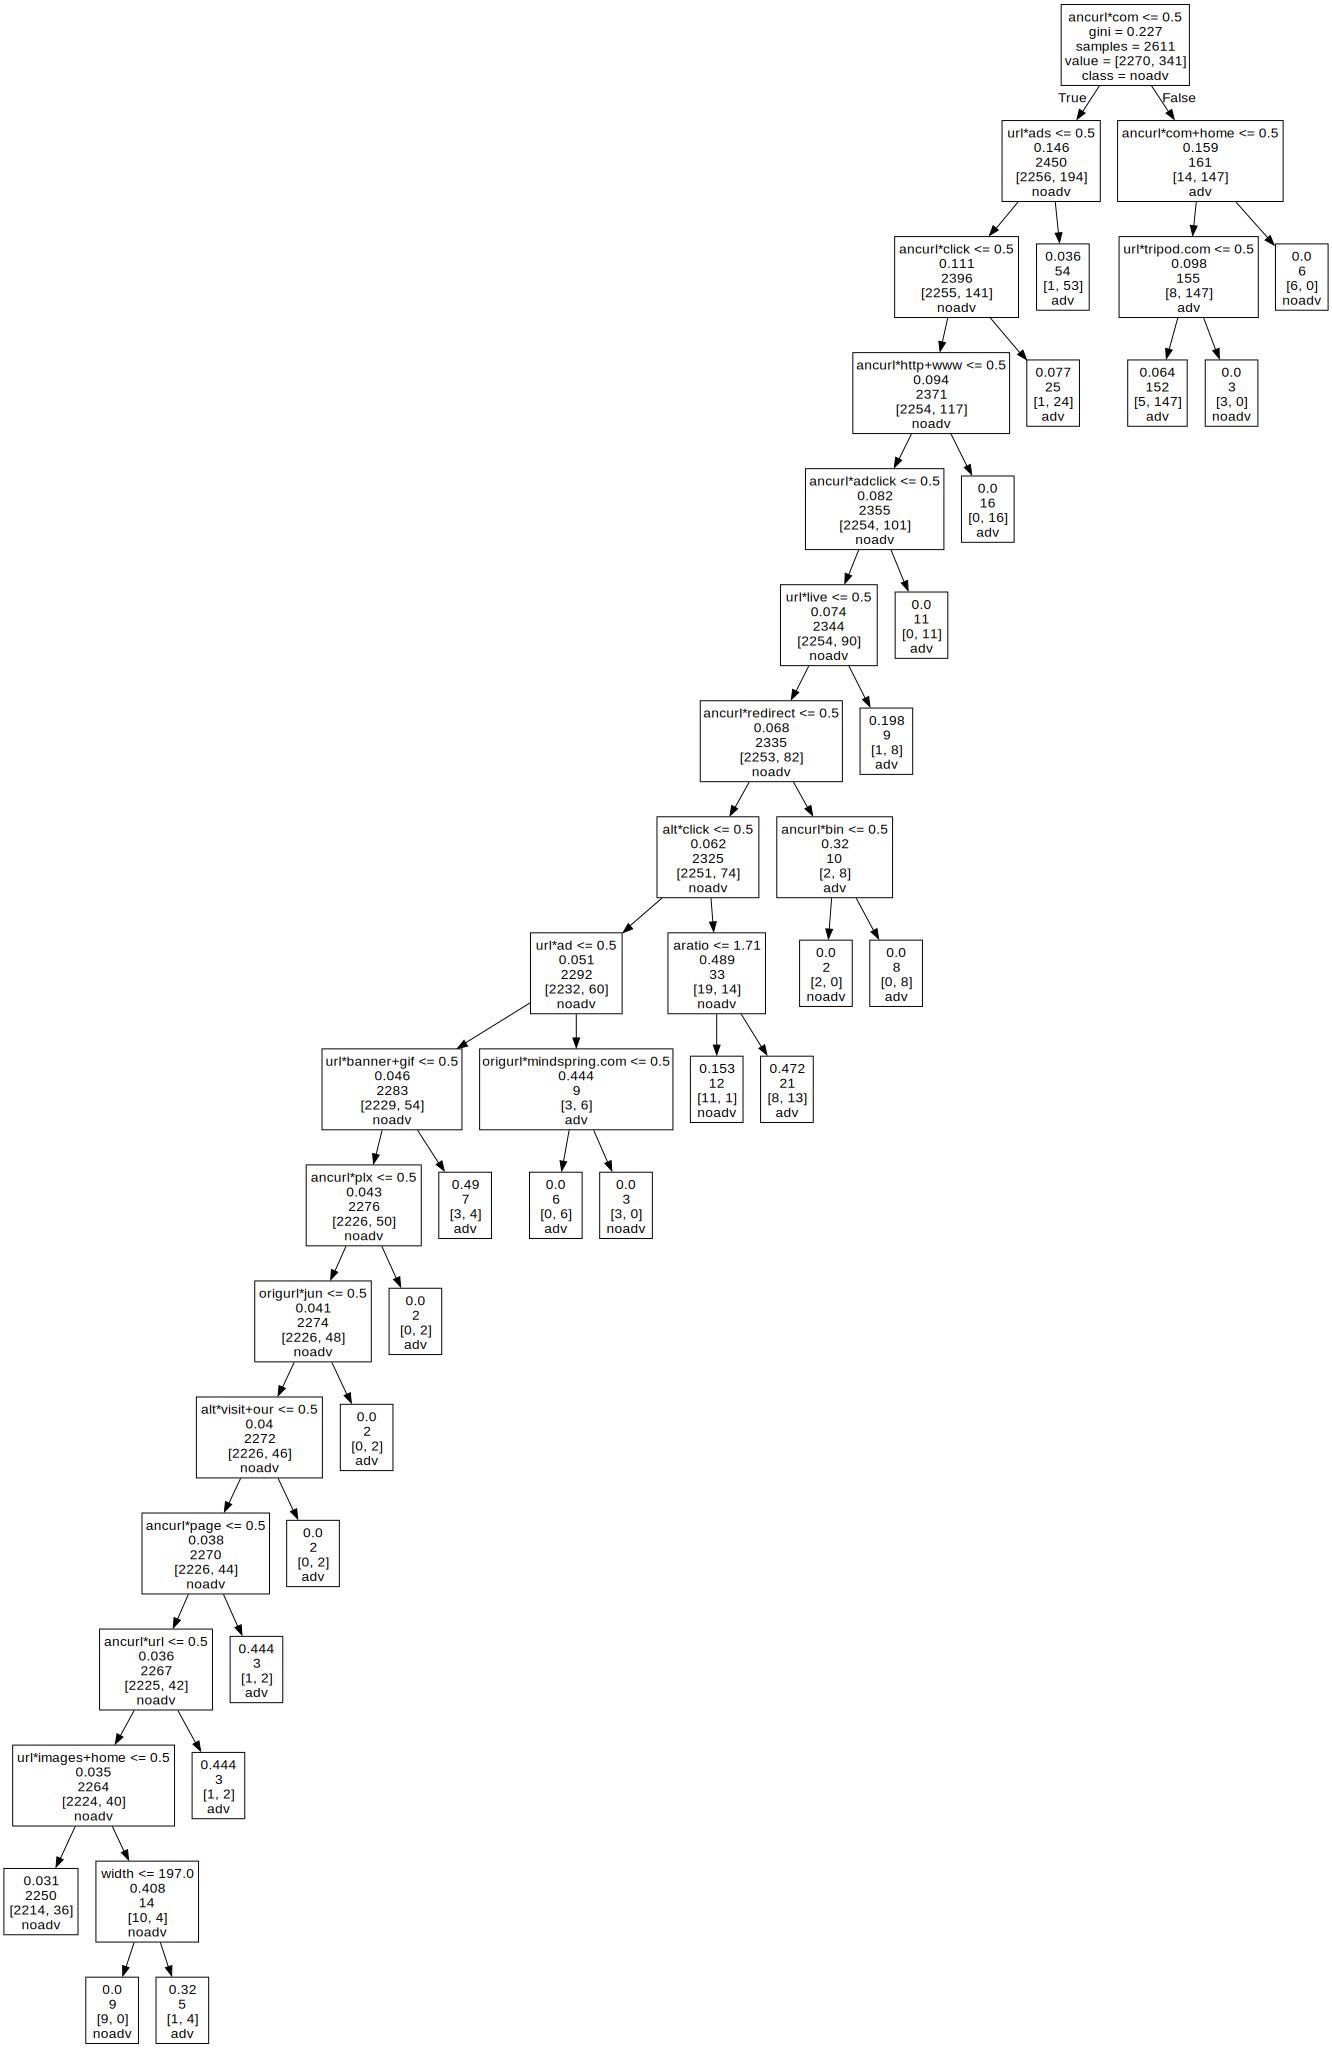

In [49]:
graph = print_dt(dt_prune, train_set_reduced)
graph

## PCA <a id="pca-dt"></a>

Si vuole adesso testare il decision tree classifier con il dataset ridotto tramite pca. Si valuta anche qui un possibile pruning tramite cross-validation.

In [319]:
dt_pca = train_dt(pca_train_set, pca_test_set)

Depth:  38
Train Metrics:
Precision:  0.9970326409495549
Recall:  0.9853372434017595
F1 Score:  0.9911504424778762
Accuracy:  0.9977020298736117

Test Metrics:
Precision:  0.9555555555555556
Recall:  0.8865979381443299
F1 Score:  0.9197860962566844
Accuracy:  0.9678800856531049



In [296]:
gr_decision_tree = GridSearchCV(DecisionTreeClassifier(), { 'ccp_alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10] })
gr_decision_tree.fit(pca_train_set.drop('Class',axis=1), pca_train_set['Class'])
gr_decision_tree.best_params_

{'ccp_alpha': 0.001}

In [297]:
dt_prune_pca = train_dt(pca_train_set, pca_test_set, ccp_alpha=0.001)

Depth:  16
Train Metrics:
Precision:  0.9675324675324676
Recall:  0.873900293255132
F1 Score:  0.9183359013867488
Accuracy:  0.9797012638835695

Test Metrics:
Precision:  0.9534883720930233
Recall:  0.845360824742268
F1 Score:  0.8961748633879781
Accuracy:  0.9593147751605996



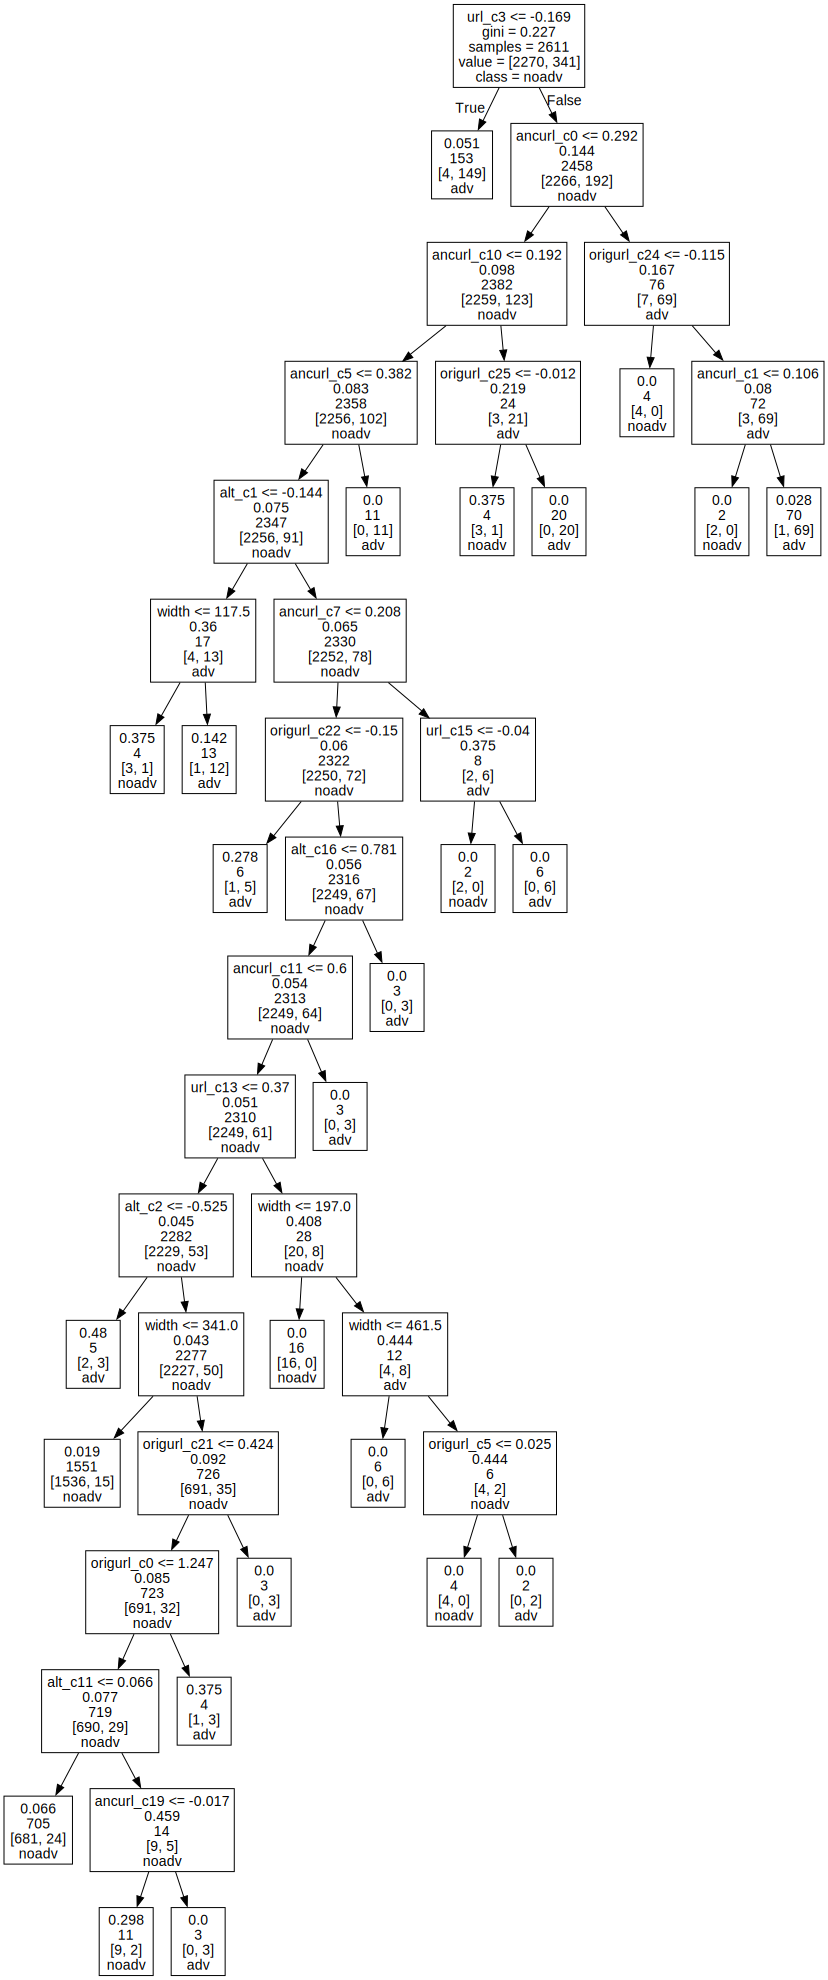

In [320]:
graph_pca = print_dt(dt_prune_pca, pca_train_set)
graph_pca

Qui si continua a verificare un leggero overfit, si testano le versioni undersampled e SMOTE. Si vuole cercare di migliorare il risultato ottenuto sul dataset di base.

In [298]:
dt_prune_pca_under = train_dt(pca_train_set_under, pca_test_set, ccp_alpha=0.001)

Depth:  15
Train Metrics:
Precision:  1.0
Recall:  0.9882697947214076
F1 Score:  0.9941002949852508
Accuracy:  0.9941348973607038

Test Metrics:
Precision:  0.75
Recall:  0.9587628865979382
F1 Score:  0.841628959276018
Accuracy:  0.9250535331905781



In [299]:
dt_prune_pca_res = train_dt(pca_train_set_oversampled, pca_test_set, ccp_alpha=0.001)

Depth:  12
Train Metrics:
Precision:  0.9856823266219239
Recall:  0.9704845814977974
F1 Score:  0.9780244173140955
Accuracy:  0.978193832599119

Test Metrics:
Precision:  0.8817204301075269
Recall:  0.845360824742268
F1 Score:  0.8631578947368421
Accuracy:  0.9443254817987152



Non si sono riscontrati miglioramenti sostanziali.

# Random Forest <a id="random-forest"></a>

Gli alberi decisionali sono facili da costruire, usare ed interpretare, ma sono spesso inaccurati. Lavorano bene con i dati usati per crearli, ma non sono molto flessibili quando si necessita di classificare nuovi sample. Random Forest combina la semplicita degli alberi decisionali con la flessibilità, risultando in una buona improvement in accuracy.

Di seguito si definisce una funzione ausiliaria:

In [41]:
def train_random_forest(train_dataset, test_dataset, plot=False, **kwargs):
    rf = RandomForestClassifier(**kwargs)
    rf.fit(train_dataset.drop('Class',axis=1),train_dataset['Class'])
    pred=rf.predict(train_dataset.drop('Class',axis=1))
    test_pred=rf.predict(test_dataset.drop('Class',axis=1))
    if plot:
        print_metrics(train_dataset['Class'],pred,test_dataset['Class'],test_pred)
        return rf
    print_metrics_no_plot(train_dataset['Class'],pred,test_dataset['Class'],test_pred)
    return rf

## Baseline <a id="baseline-rf"></a>

In [42]:
params_grid = { 'n_estimators': [200,300,500,600,700,800,1000], #numero di alberi
                'max_depth': [2,5,10,15]}
gr_rf = GridSearchCV(RandomForestClassifier(), params_grid)
gr_rf.fit(train_set_reduced.drop('Class',axis=1), train_set_reduced['Class'])
gr_rf.best_params_

{'max_depth': 15, 'n_estimators': 600}

Train Accuracy:  0.9712753734201456
Test Accuracy:  0.9571734475374732


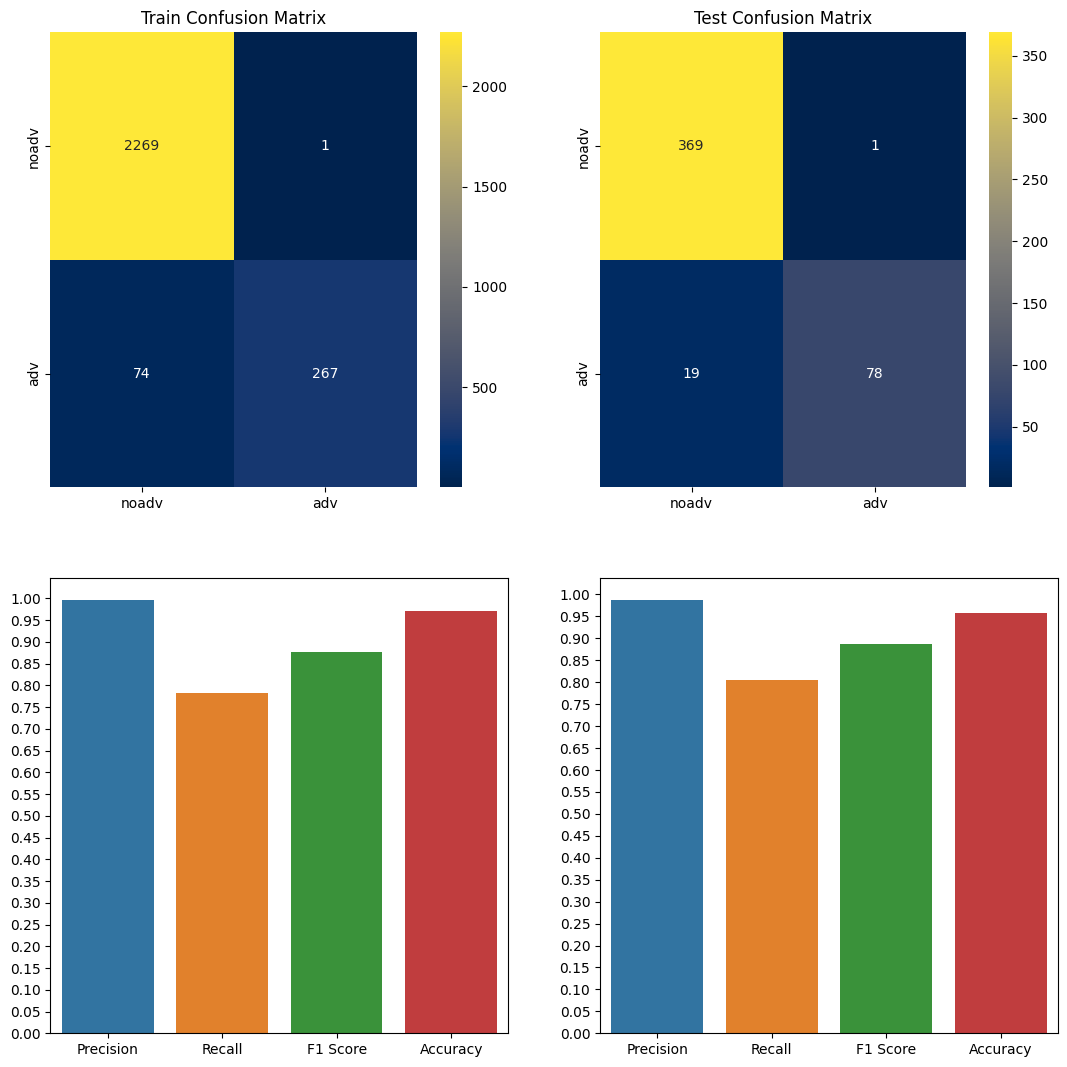

In [43]:
rf = train_random_forest(train_set_reduced, test_set_reduced, plot=True, n_estimators=600, max_depth=15)

Considerando i risultati di accuracy sulla baseline, essi sono comparabili con quelli dell'Albero di decisione. Random forest è più perdonante.

In [48]:
params_grid = { 'n_estimators': [200,300,500,600,700,800,1000], #numero di alberi
                'max_depth': [2,5,10,15]}
gr_rf = GridSearchCV(RandomForestClassifier(), params_grid)
gr_rf.fit(train_set_reduced_oversampled.drop('Class',axis=1), train_set_reduced_oversampled['Class'])
gr_rf.best_params_

{'max_depth': 15, 'n_estimators': 700}

Train Accuracy:  0.871806167400881
Test Accuracy:  0.961456102783726


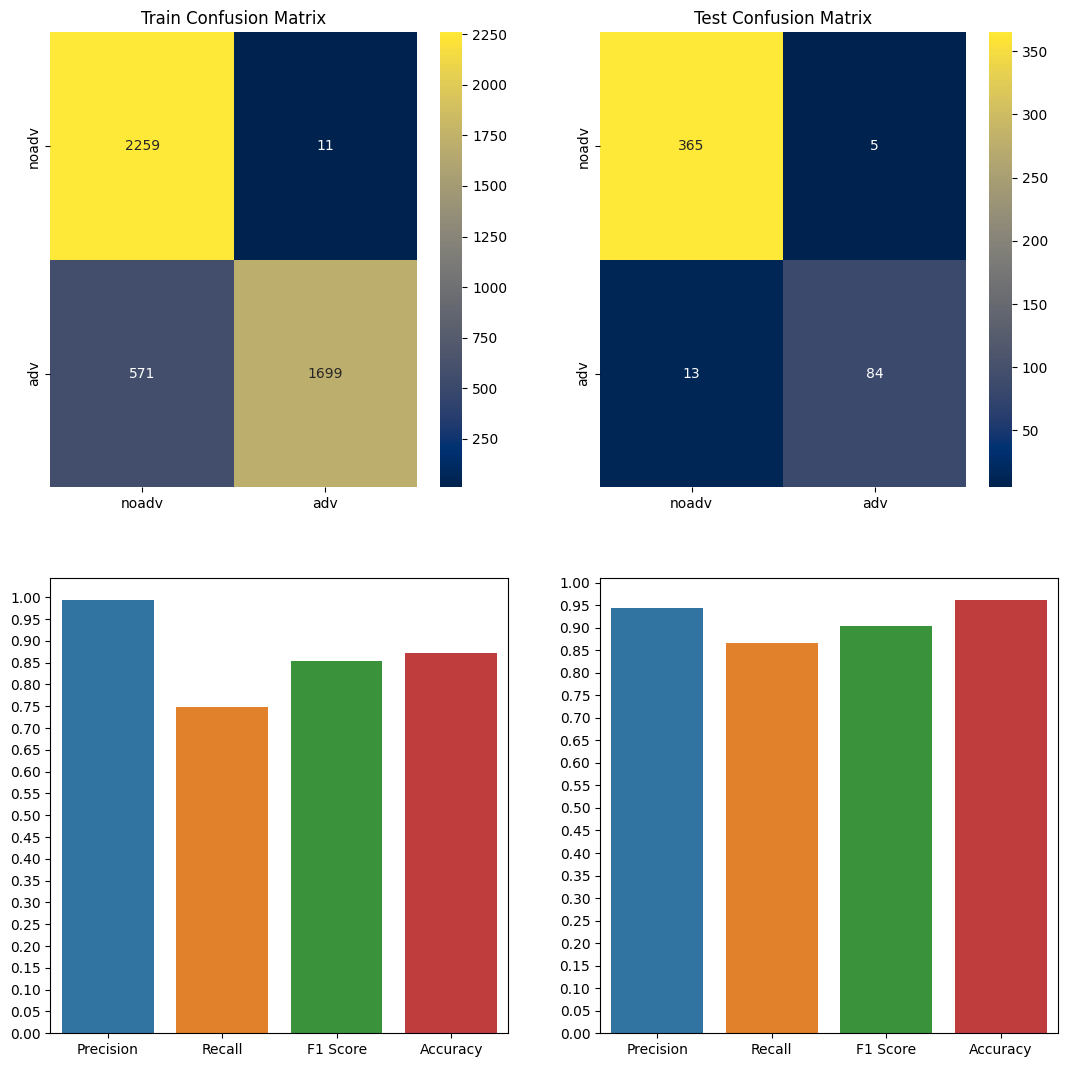

In [62]:
rf_oversampled = train_random_forest(train_set_reduced_oversampled, test_set_reduced, plot=True, n_estimators=700, max_depth=15)

## PCA <a id="pca-rf"></a>

In [45]:
params_grid = { 'n_estimators': [200,300,500,600,700,800,1000], #numero di alberi
                'max_depth': [2,5,10,15]}
gr_rf = GridSearchCV(RandomForestClassifier(), params_grid)
gr_rf.fit(pca_train_set.drop('Class',axis=1), pca_train_set['Class'])
gr_rf.best_params_

{'max_depth': 15, 'n_estimators': 500}

Train Accuracy:  0.9839142091152815
Test Accuracy:  0.961456102783726


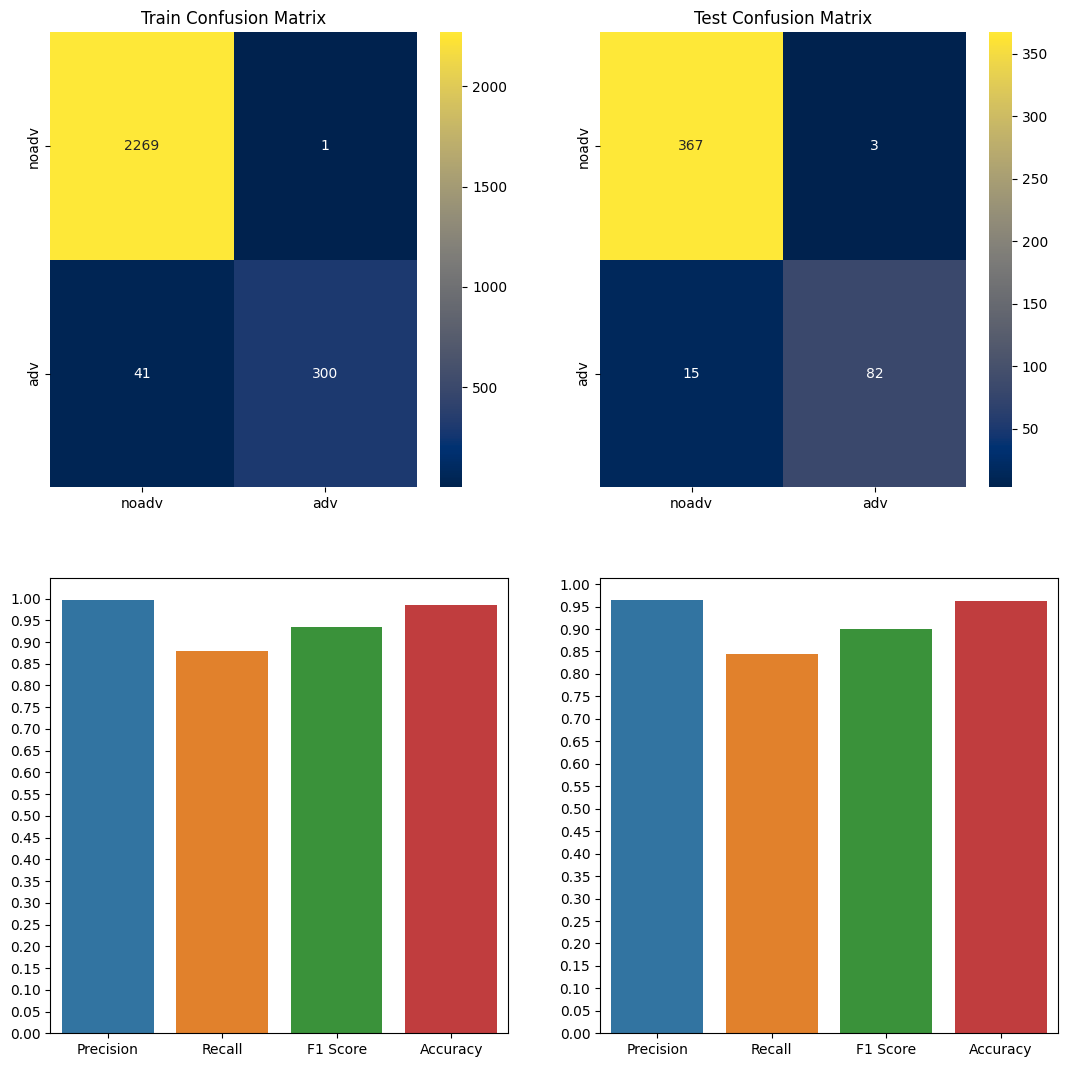

In [63]:
rf = train_random_forest(pca_train_set, pca_test_set, n_estimators=500, max_depth=15, plot=True)

In [46]:
params_grid = { 'n_estimators': [200,300,500,600,700,800,1000], #numero di alberi
                'max_depth': [2,5,10,15]}
gr_rf = GridSearchCV(RandomForestClassifier(), params_grid)
gr_rf.fit(pca_train_set_under.drop('Class',axis=1), pca_train_set_under['Class'])
gr_rf.best_params_

{'max_depth': 15, 'n_estimators': 1000}

Train Accuracy:  0.9853372434017595
Test Accuracy:  0.961456102783726


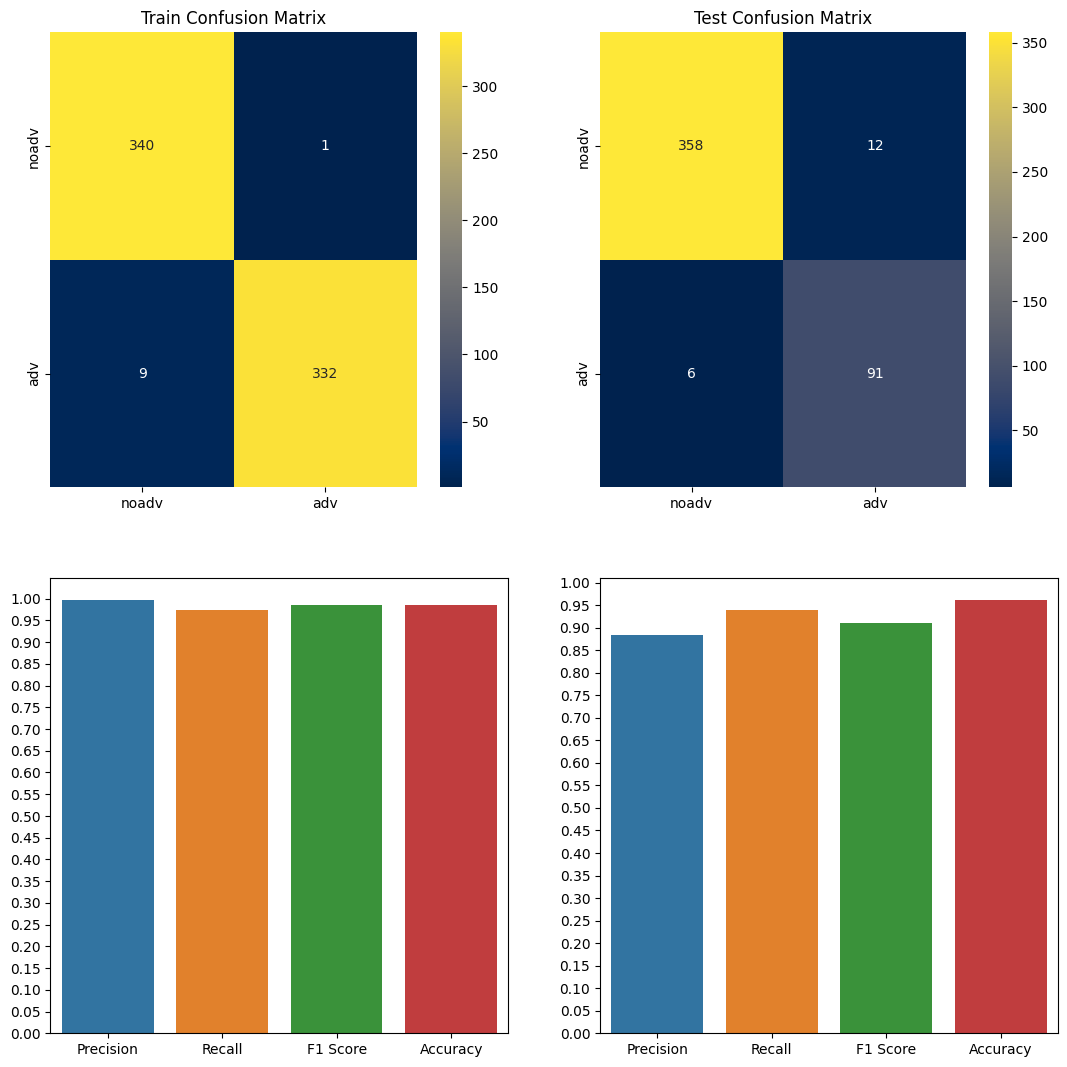

In [51]:
rf = train_random_forest(pca_train_set_under, pca_test_set, n_estimators=1000, max_depth=15, plot=True)

In [47]:
params_grid = { 'n_estimators': [200,300,500,600,700,800,1000], #numero di alberi
                'max_depth': [2,5,10,15]}
gr_rf = GridSearchCV(RandomForestClassifier(), params_grid)
gr_rf.fit(pca_train_set_oversampled.drop('Class',axis=1), pca_train_set_oversampled['Class'])
gr_rf.best_params_

{'max_depth': 15, 'n_estimators': 700}

Train Accuracy:  0.9947136563876652
Test Accuracy:  0.974304068522484


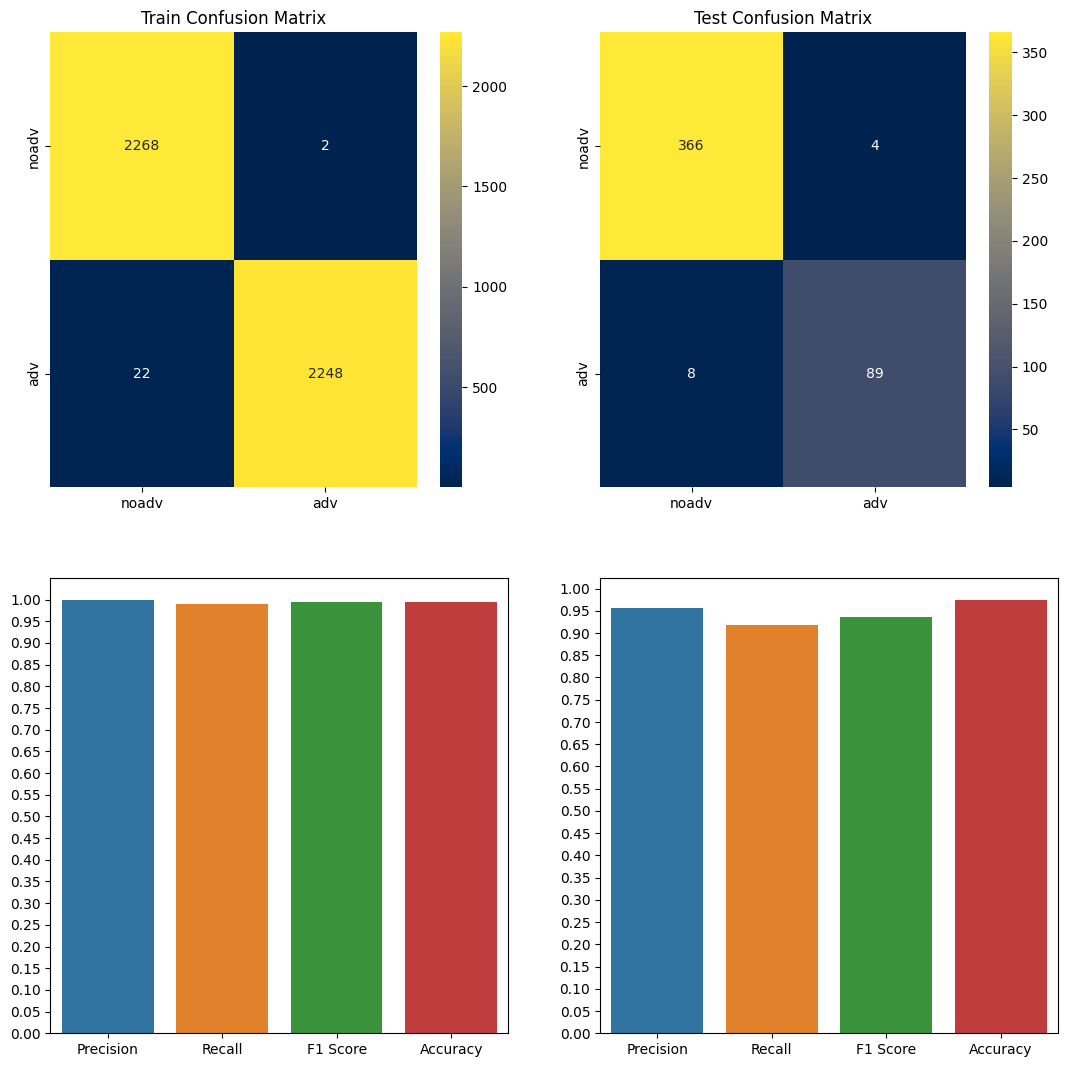

In [65]:
rf = train_random_forest(pca_train_set_oversampled, pca_test_set, n_estimators=700, max_depth=15, plot=True)

PCA base senza sampling ottiene comunque buone prestazioni rispetto alla baseline.

# K-NN <a id="k-nn"></a>

Il K-Nearest Neighbors (KNN) è un algoritmo di apprendimento supervisionato non parametrico utilizzato per la classificazione. Si basa su un concetto semplice: i punti di dati simili si trovano vicini tra loro. L'algoritmo funziona memorizzando tutti i punti di dati disponibili e classificando i nuovi punti di dati in base a una misura di similarità (ad esempio, una funzione di distanza). 

In [53]:
def train_knn(train_dataset, test_dataset, plot=False, **kwargs):
    rf = KNeighborsClassifier(**kwargs)
    rf.fit(train_dataset.drop('Class',axis=1),train_dataset['Class'])
    pred=rf.predict(train_dataset.drop('Class',axis=1))
    test_pred=rf.predict(test_dataset.drop('Class',axis=1))
    if plot:
        print_metrics(train_dataset['Class'],pred,test_dataset['Class'],test_pred)
        return rf
    print_metrics_no_plot(train_dataset['Class'],pred,test_dataset['Class'],test_pred)
    return rf

La scelta del parametro k, che rappresenta il numero di vicini più prossimi da considerare, è fondamentale per l'efficacia del modello e si basa sui dati di training. Si procede dunque ad avviare una grid search esaustiva per individuare il miglior parametro K.

In [58]:
param_grid = [{'n_neighbors': range(1, 20, 2), 'metric': ['manhattan', 'minkowski']}]  # solo numeri dispari visto la classificazione binaria
gs = GridSearchCV(KNeighborsClassifier(), param_grid)
gs.fit(train_set_reduced.drop('Class',axis=1), train_set_reduced['Class'])
best_knn = gs.best_estimator_
print("Migliore valore di K trovato per il training set: %d" % best_knn.n_neighbors)
print("Migliore metrica: ", best_knn.metric)

Migliore valore di K trovato per il training set: 1
Migliore metrica:  manhattan


## Baseline

Train Accuracy:  0.9973190348525469
Test Accuracy:  0.9421841541755889


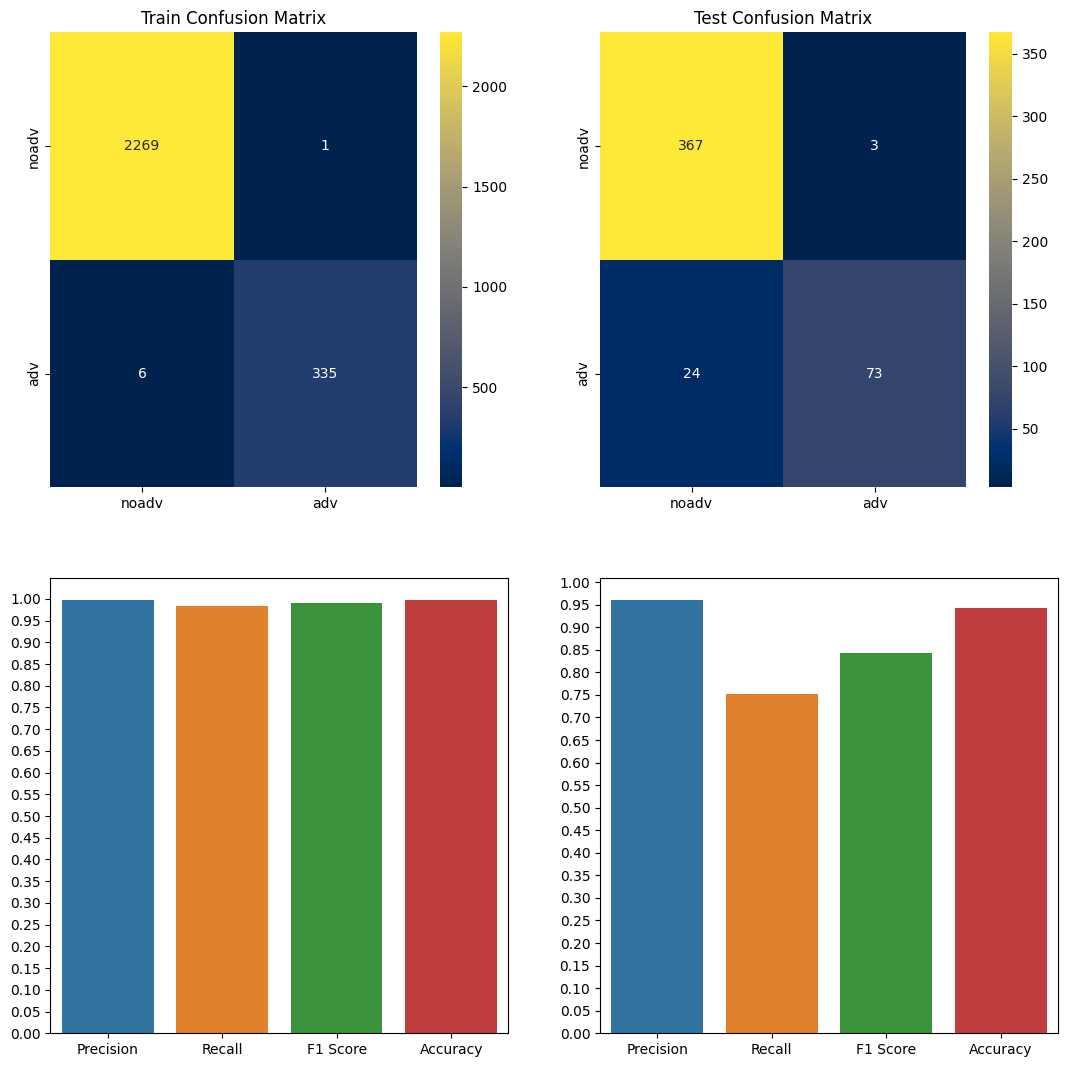

In [59]:
knn = train_knn(train_set_reduced, test_set_reduced, plot=True, n_neighbors=1, metric='manhattan')

Con K-NN il dataset originale poco bilanciato effettua molti errori verso la classe dominante, risultando in un numero di FN alto ed una recall bassa, è un po' troppo perdonante.

Train Accuracy:  0.9508810572687225
Test Accuracy:  0.9229122055674518


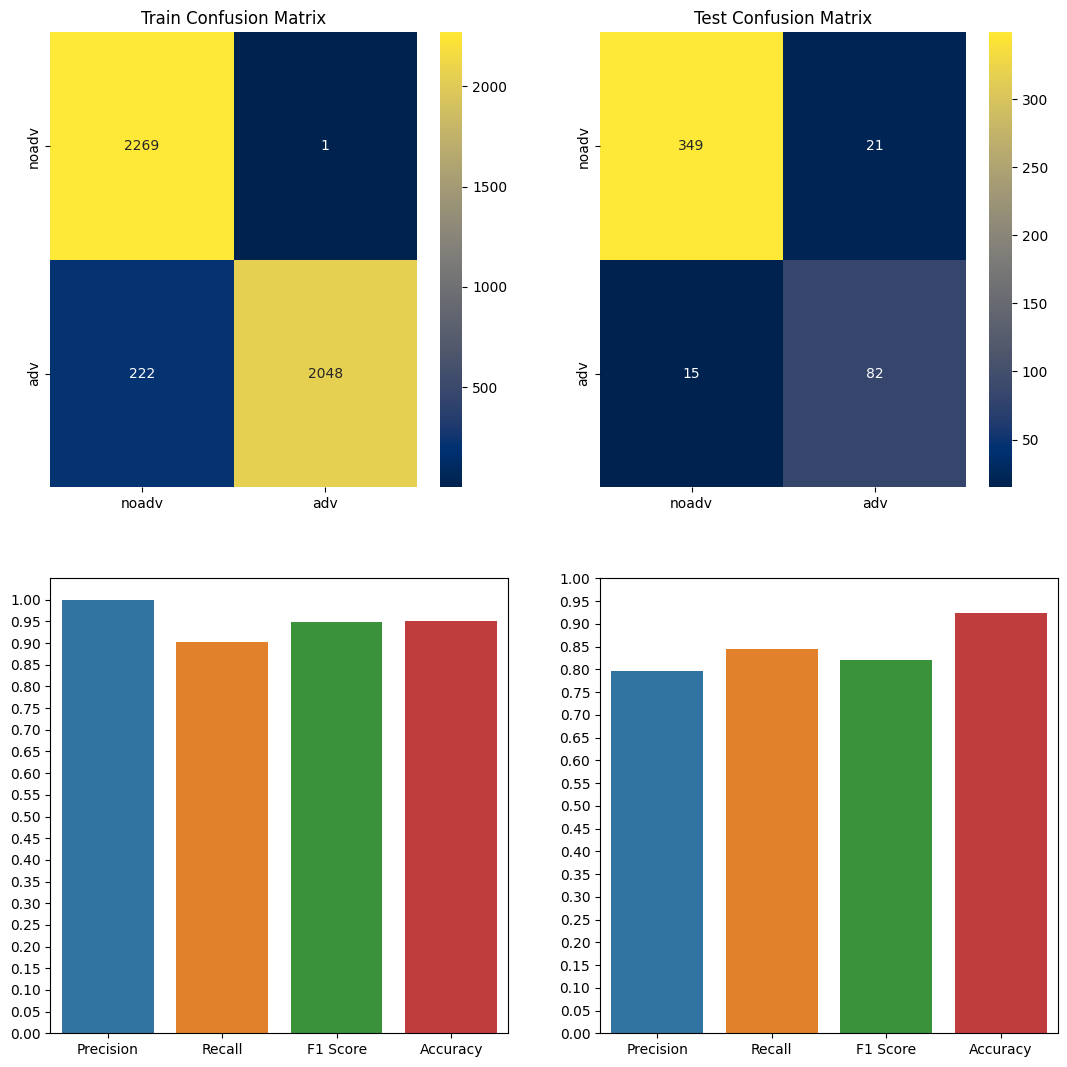

In [60]:
knn = train_knn(train_set_reduced_oversampled, test_set_reduced, plot=True, n_neighbors=1, metric='manhattan')

La situazione viene riequilibrata.

## PCA

In [64]:
param_grid = [{'n_neighbors': range(1, 20, 2)}]  # solo numeri dispari visto la classificazione binaria
gs = GridSearchCV(KNeighborsClassifier(), param_grid)
gs.fit(pca_train_set.drop('Class',axis=1), pca_train_set['Class'])
best_knn = gs.best_estimator_
print("Migliore valore di K trovato per il training set: %d" % best_knn.n_neighbors)

Migliore valore di K trovato per il training set: 3


Train Accuracy:  0.9685944082726925
Test Accuracy:  0.9271948608137045


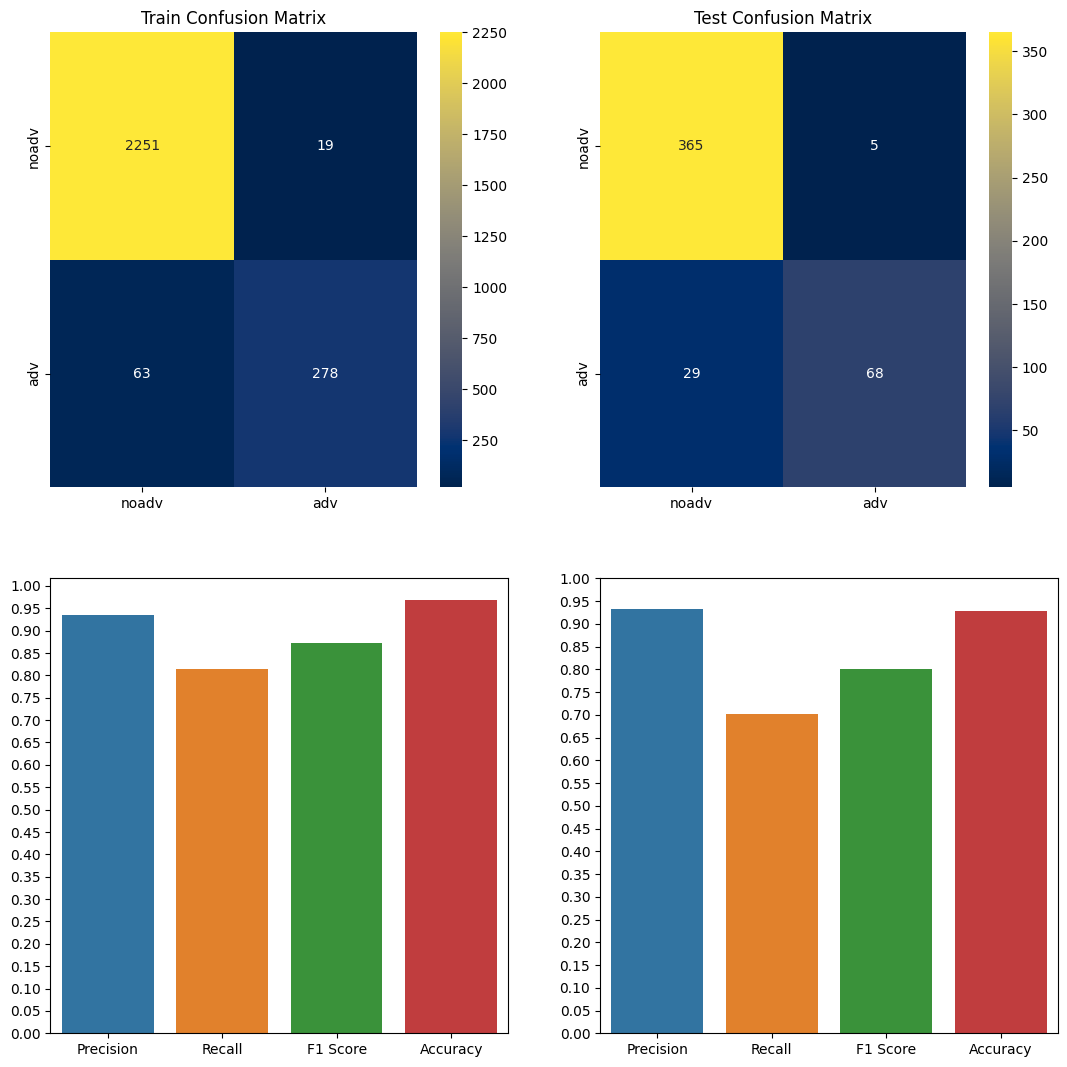

In [63]:
knn = train_knn(pca_train_set, pca_test_set, plot=True, n_neighbors=3)

In [71]:
knn = train_knn(pca_train_set_under, pca_test_set, plot=False, n_neighbors=3)

Train Metrics:
Precision:  0.8924418604651163
Recall:  0.9002932551319648
F1 Score:  0.8963503649635035
Accuracy:  0.8958944281524927

Test Metrics:
Precision:  0.6296296296296297
Recall:  0.8762886597938144
F1 Score:  0.732758620689655
Accuracy:  0.867237687366167



Train Accuracy:  0.9757709251101322
Test Accuracy:  0.9143468950749465


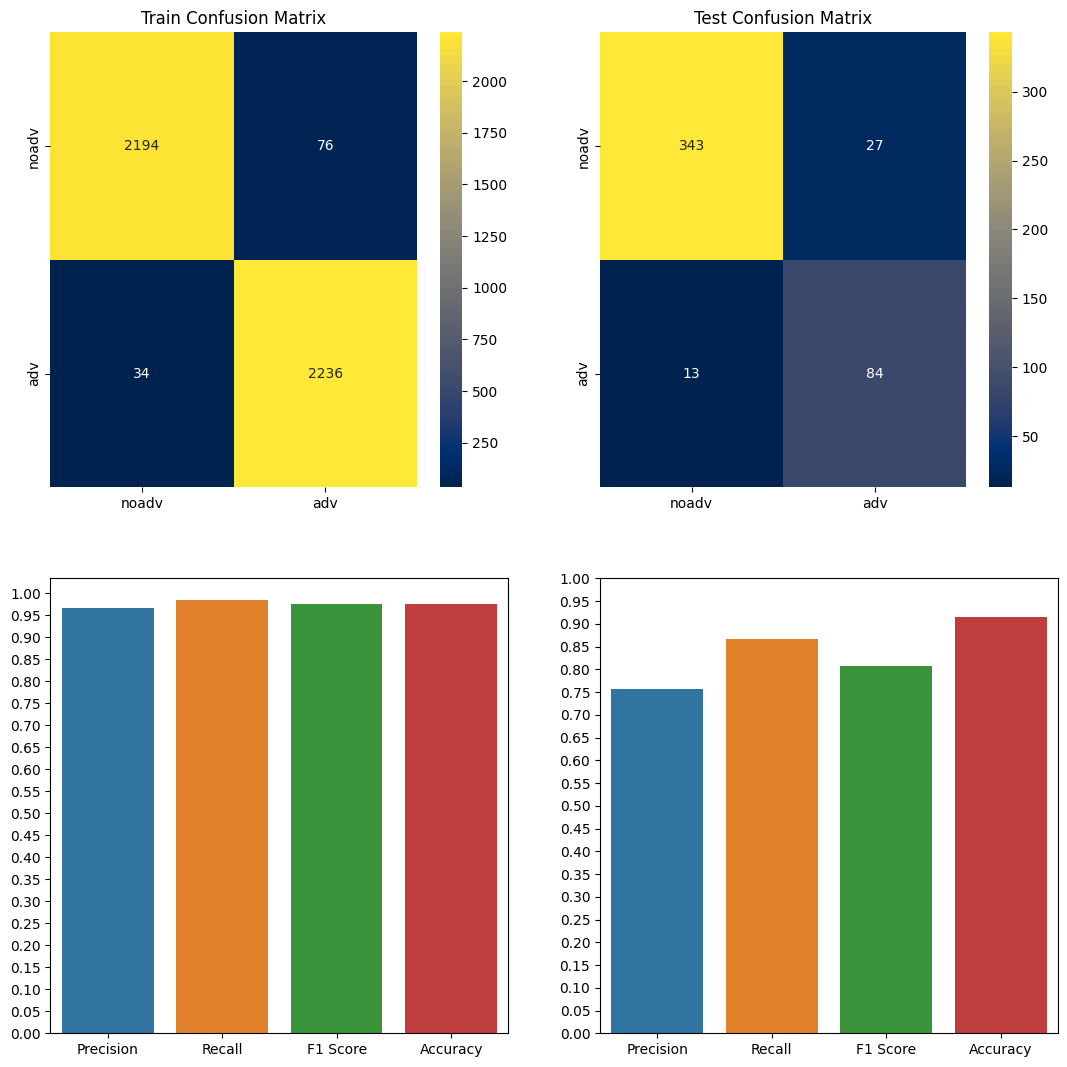

In [75]:
knn = train_knn(pca_train_set_oversampled, pca_test_set, plot=True, n_neighbors=3)

L'oversampling ha prodotto un classificatore più sospettoso.

# Clustering <a id="clustering"></a>

Il clustering è una tecnica di apprendimento non supervisionato che raggruppa un insieme di oggetti in modo tale che gli oggetti nello stesso gruppo (chiamato un cluster) siano più simili tra loro secondo una determinata funzione distanza, rispetto a quelli in altri cluster. 

## K-Medoids <a id="k-medoids"></a>

K-medoids è un algoritmo di clustering particolarmente utile quando la funzione di distanza scelta è non euclidea e robusta agli outlier. A differenza del K-means, che calcola il centroide come il punto medio di un cluster, il K-medoids seleziona un punto effettivo del dataset come centro del cluster, il medoide, che è il punto più rappresentativo di un cluster secondo la funzione distanza scelta. Questo lo rende più resistente agli outlier e capace di gestire vari tipi di dati, inclusi quelli categorici o binari.

## Baseline

In [67]:
X = train_set_reduced.drop('Class', axis=1)

kmedoids = KMedoids(n_clusters=2, metric='manhattan')
kmedoids.fit(X)

clusters = kmedoids.labels_

print(clusters[:10])

[1 0 0 0 0 1 0 0 0 1]


Il silhouette score è una misura di quanto bene ogni punto di un dataset si adatta al suo cluster assegnato. Il valore del silhouette score varia tra -1 e 1 e un valore elevato indica che un punto è ben adattato al suo cluster. 

In [68]:
print('Silhouette Score: ', silhouette_score(X, clusters))

Silhouette Score:  0.7911795305778877


C:\Users\danil\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\extmath.py:189: RuntimeWarning:

invalid value encountered in matmul



Si vuole mostrare il plot al variare di k l'Elbow Method. L'**inertia_**, o la somma delle distanze al quadrato tra ciascun campione nel cluster e il centro del cluster (il medoide), è una misura della coesione del cluster. Più bassa è l'inertia_, più vicini sono i punti del cluster al loro medoide, il che significa che i cluster sono più "compatti".

/Users/danilosantitto/.local/lib/python3.11/site-packages/sklearn/utils/extmath.py:189: RuntimeWarning:

invalid value encountered in matmul

/Users/danilosantitto/.local/lib/python3.11/site-packages/sklearn/utils/extmath.py:189: RuntimeWarning:

invalid value encountered in matmul

/Users/danilosantitto/.local/lib/python3.11/site-packages/sklearn/utils/extmath.py:189: RuntimeWarning:

invalid value encountered in matmul

/Users/danilosantitto/.local/lib/python3.11/site-packages/sklearn/utils/extmath.py:189: RuntimeWarning:

invalid value encountered in matmul

/Users/danilosantitto/.local/lib/python3.11/site-packages/sklearn/utils/extmath.py:189: RuntimeWarning:

invalid value encountered in matmul



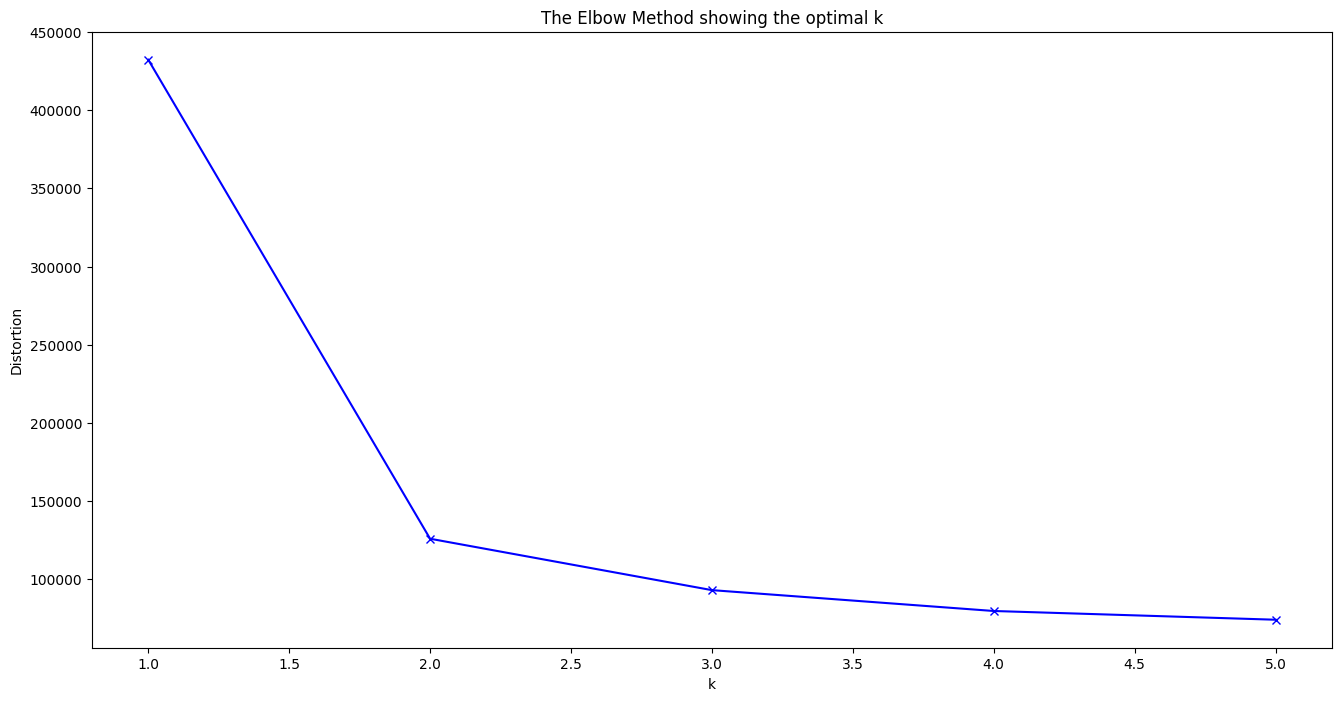

In [70]:
distortions = []
K = range(1,6)
for k in K:
    kmed = KMedoids(n_clusters=k, random_state=0)
    kmed.fit(X)
    distortions.append(kmed.inertia_)

plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

L'obiettivo del grafico Elbow è quello di trovare un "equilibrio" tra avere un numero elevato di cluster (che potrebbe portare a un'overfitting e a cluster molto specifici e meno generalizzabili) e avere un'inerzia bassa. Il "gomito" nel grafico, che è il punto in cui l'inerzia_ comincia a diminuire più lentamente, può indicare un buon numero di cluster da utilizzare. Non c'è una diminuzione significativa dell'inertia_ all'aumentare del numero di cluster dopo questo punto.

Si noti come dopo k=2 non si nota un netto miglioramento nella distorsione, dunque l'elbow è proprio in k=2, che si rivela il miglior numero di cluster, concorde alla classificazione binaria per cui il dataset si predispone.

## PCA

In [71]:
X = pca_train_set.drop('Class', axis=1)

kmedoids = KMedoids(n_clusters=2)
kmedoids.fit(X)

clusters = kmedoids.labels_

print(clusters[:10])

[0 1 1 1 1 0 1 1 1 0]


In [72]:
print('Silhouette Score: ', silhouette_score(X, clusters))

Silhouette Score:  0.7920358211206515


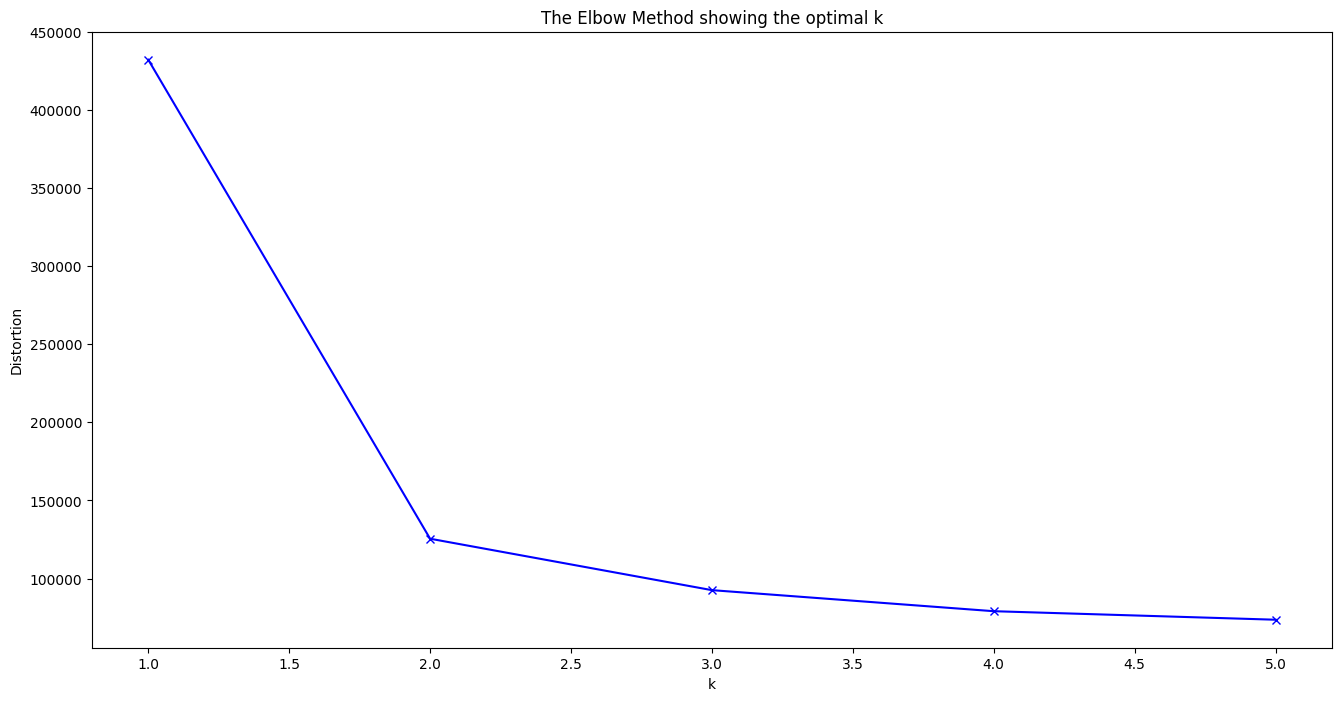

In [73]:
distortions = []
K = range(1,6)
for k in K:
    kmed = KMedoids(n_clusters=k, random_state=0)
    kmed.fit(X)
    distortions.append(kmed.inertia_)

plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()


# Conclusioni <a id="conclusioni"></a>

Lo studio condotto ha portato a diverse conclusioni chiave in merito all'analisi del dataset considerato. Di seguito sono sintetizzate le considerazioni principali.

Il dataset originale presentava un numero elevato di features che complicavano notevolmente l'analisi di tipo regressione. Tale complessità era amplificata dalla predominanza di variabili dummy sparse nel dataset. Infatti, solo una frazione minima di queste superava un conteggio pari all'1-2% del totale dei record, generando una bassa varianza per ogni variabile dummy e inducendo problematiche di convergenza nel corso dell'applicazione della regressione logistica.

Tali ostacoli sono stati superati attraverso un'attenta analisi della multicollinearità, che ha permesso di ridurre in modo significativo il numero di variabili coinvolte, da 1558 a 712. L'applicazione dell'Analisi delle Componenti Principali (PCA) ha ulteriormente limitato il numero di features a 107, pur conservando il 65% della varianza totale.

I risultati ottenuti rappresentano una conferma dell'efficacia delle tecniche di riduzione della dimensionalità e dell'impiego di diversi algoritmi di machine learning per l'analisi di dataset ad alta dimensionalità e complessità.

L'applicazione della regressione logistica per la classificazione binaria ha prodotto risultati di notevole interesse, suggerendo la possibilità di una separazione lineare del dataset. I risultati ottenuti sul test set sono riportati nel paragrafo successivo.

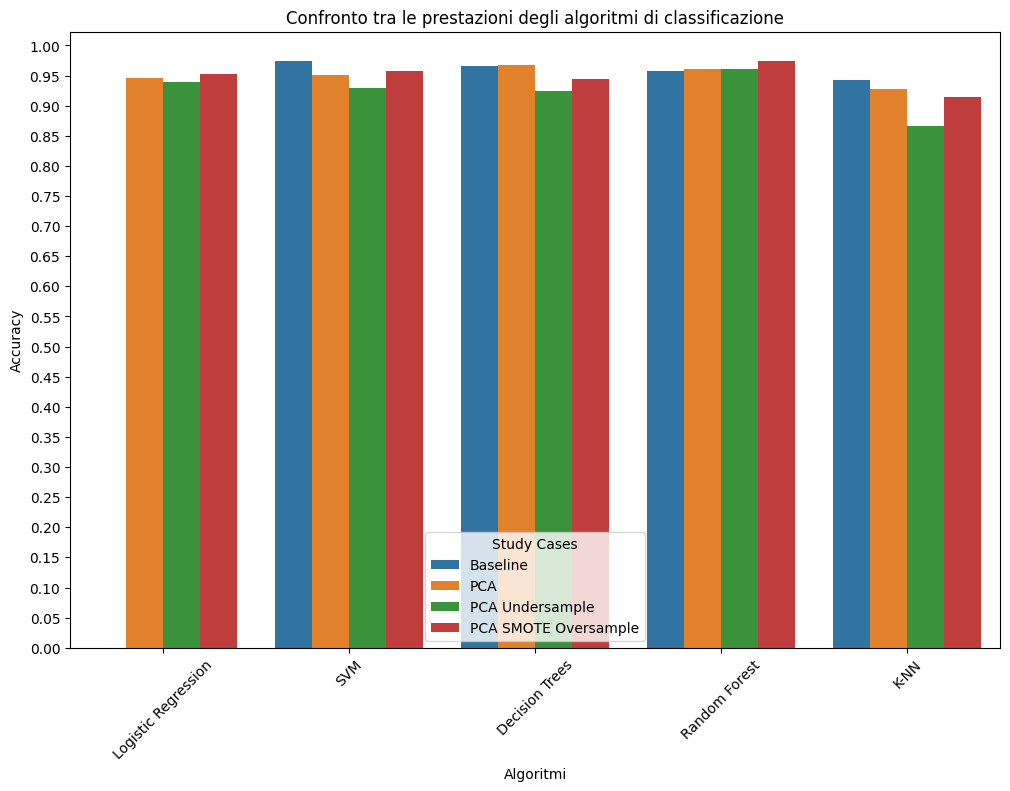

In [66]:
data = {
    'Algorithm': ['Logistic Regression', 'SVM', 'Decision Trees', 'Random Forest', 'K-NN'],
    'Baseline': [None, 0.974, 0.966, 0.957, 0.942],
    'PCA': [0.946, 0.951, 0.968, 0.961, 0.927],
    'PCA Undersample': [0.940, 0.929, 0.925, 0.961, 0.867],
    'PCA SMOTE Oversample': [0.953, 0.957, 0.944, 0.974, 0.914],
}

df = pd.DataFrame(data)
df = pd.melt(df, id_vars="Algorithm", var_name="Study Cases", value_name="Accuracy")
plt.figure(figsize=(12, 8))
g = sns.barplot(x='Algorithm', y='Accuracy', hue='Study Cases', data=df)
g.set_yticks(np.arange(0, 1.01, 0.05))
plt.title('Confronto tra le prestazioni degli algoritmi di classificazione')
plt.ylabel('Accuracy')
plt.xlabel('Algoritmi')
plt.xticks(rotation=45)
plt.show()


In generale tutti gli algoritmi hanno ottenuto un'elevata accuracy sul test set di oltre il 90%. Nonostante il dataset risultasse fortemente sbilanciato, spesso la baseline si è comportata meglio dei dataset a cui è stato applicato Undersamplig o Oversampling.

Di seguito, per approfondimento, in dettaglio i valori ottenuti e i parametri utilizzati. Le etichette 'Baseline' e 'PCA' si riferiscono rispettivamente all'applicazione degli algoritmi al dataset ridotto dopo l'analisi della multicollinearità e al dataset ridotto ulteriormente tramite PCA:

Regressione e Classificazione:
* Regressione Logistica:
    * Baseline: N.D.
    * PCA: accuracy: 0.9464668094218416, dataset sbilanciato, recall bassa, perdonante
    * PCA Lasso: accuracy: 0.9486081370449678, di poco migliore della precedente, caratteristiche simili
    * PCA Unsersample: accuracy: 0.9400428265524625, a parità di prestazioni in accuracy, risulta un classificatore più equilibrato
    * PCA Oversample SMOTE: accuracy: 0.9528907922912205, leggermente migliore, recall più bassa, perdonante.
* SVM:
    * Baseline: accuracy: 0.974304068522484, abbastanza equilibrato, migliora il caso della regressione
    * PCA: accuracy: 0.9507494646680942, perdonante
    * PCA Unsersample: accuracy: 0.9293361884368309, recall > precision, sospettoso
    * PCA Oversample: accuracy: 0.9571734475374732, perdonante
* Alberi Decisionali:
    * Baseline: accuracy: 0.9657387580299786, depth: 90, equilibrato
    * Baseline Prune: accuracy: 0.9700214132762313, depth: 17, equilibrato
    * PCA: accuracy: 0.9678800856531049, depth: 38, equilibrato
    * PCA Prune: accuracy: 0.9593147751605996, depth: 16, recall < precision
    * PCA Prune Unsersample: accuracy: 0.9250535331905781, depth: 15, recall < precision
    * PCA Oversample: accuracy: 0.9443254817987152, depth: 15, recall < precision
* Random Forest:
    * Baseline: accuracy: 0.9571734475374732, {'max_depth': 15, 'n_estimators': 600}, equilibrato
    * PCA: accuracy: 0.961456102783726, {'max_depth': 15, 'n_estimators': 500}, perdonante
    * PCA Unsersample: accuracy: 0.961456102783726, {'max_depth': 15, 'n_estimators': 1000}, recall > precision
    * PCA Oversample: accuracy:  0.974304068522484, {'max_depth': 15, 'n_estimators': 700}, equilibrato
* K-NN (K=2, rilevato con gridsearchcv):
    * Baseline: accuracy: 0.9379014989293362, recall << precision
    * Baseline SMOTE: accuracy: 0.9229122055674518, recall simile a precision, equilibrato
    * PCA: accuracy: 0.9271948608137045,  recall << precision
    * PCA Unsersample: accuracy: 0.867237687366167, equilibrato
    * PCA Oversample: accuracy: 0.9143468950749465, meno equilibrato del precedente

Clustering:
* K-Medoids:
    * Baseline: Silhouette Score: 0.791395807968198, k=2
    * PCA: Silhouette Score:  0.7920358211206515, k=2

#### Il progetto di analisi discusso sopra è stato sviluppato dal Dott. Danilo Santitto per il corso di Fondamenti di Analisi dei Dati, al Dipartimento di Matematica e Informatica, UniCT.